# **Tutorial** : create your own base map from A to Z with CartAGen, from IGN's BD TOPO
![Alt text](https://assets-global.website-files.com/63483ad423421bd16e7a7ae7/63a16770a97b930a84c77f00_voyager-positron.png)

_Source : https://carto.com/blog/new-voyager-basemap_ \
Press **`space bar`** to show next slide 

- 🙋 **For whom ?** : 
    - cartographers wishing to obtain a **customized background map** to enhance their cartographic projects, with an **open source** solution
    - **national mapping institutes** and other organizations wishing to discover the **cartographic generalization possibilities** offered by the CartAGen tool
    - anyone who wants to understand how **topographic maps** are made!

Press **`space bar`** to show next message

- ❓ **What is CartAGen ?** :
    - an **open source Python library** made by **IGN** (i.e the french national mapping agency) researchers
    - a tool to carry out cartographic generalization processes and **automate** them
    - a **QGIS plugin** to use the Python library in a GIS environment  
    
Press **`space bar`** and **`scroll down`** to show next message 

- 📗 **How to use this Notebook ?** : 
    - a Notebook is a document that mixes **markdown cells** (i.e. cells with formatted text like this one) and **code cells**, which you can modify and execute at will
    - it comes with a **sample data set** on which you can **test** the various features of the CartAGen python library
    - you can import your **own data** and run the code cells of this Notebook, or use the CartAGen tool in **another environment** (QGIS or python script)
    
Press **`right arrow`** to show next slide and start part 0, press **`space bar`** to show sub-slide and see useful links

- 🔗 **Useful links** : 
    - [Github repository](https://github.com/LostInZoom/cartagen4py?tab=readme-ov-file) 
    - [CartAGen documentation](https://cartagen4py.readthedocs.io/en/latest/index.html)
    - [IGN's BD TOPO](https://geoservices.ign.fr/bdtopo)

_by Paul Bourcier, 2024 - CC-BY-SA 4.0_

Press **`space bar`** to show next slide, press **`shift + space bar`** to go backward\
**`Click`** question mark icon to show other shortcuts

## ⚙️ **Part 0 :** Preparing the working environment

Press **`space bar`** to show code cell, then press **`shift + enter`** to execute it\
**`*`** symbol means code output is loading

In [1]:
# 0.1/ Importing libraries

from matplotlib import pyplot as plt # for ploting results, especially maps
import cartagen4py as c4 # the main library, containing cartographic generalization algorithms
import geopandas as gp # used to import and manipulate geographic data
import pandas as pd # used to concatenate datas
import ipywidgets # creation of interactive plots
import os # navigation within the environnement
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar # adding scalebar to the maps
import matplotlib.colors as matcol # generating color palettes
from matplotlib.figure import Figure # Plot generation
from mpl_toolkits.axisartist.axislines import Subplot # Plot generation
from shapely.geometry import Polygon, MultiPolygon # Create and manipulate geometries
from shapely.wkt import loads # Create and manipulate geometries
from shapely import intersects
from shapely.ops import linemerge
from tqdm.notebook import tqdm # Creating loading bar
from time import sleep # Creating loading bar
import numpy as np # Using mathematical operations in Python
import re # regex
from IPython.display import clear_output, Image # used to delete widgets

import warnings # Remove warnings
warnings.filterwarnings("ignore", category=UserWarning, message=".*GeoDataFrame you are attempting to plot is empty.*") # Remove user warning 
warnings.filterwarnings("ignore", category=UserWarning, message=".*CRS not set for some of the concatenation inputs.*.")

**0.2/** Configuring screen for figure size

In [2]:
# Configuring screen for figure size
conv = 0
SCREEN = 0
def cal_screen(size):
    global conv
    global SCREEN
    print("Configure the picture so it fits a real credit card :")
    display(Image('data/CreditCard.png', width=size))
    conv = 1/100*(size/3.37007874)

    SCREEN = {
    '1:25000':(2.45*conv,2.45*conv), 
    '1:10000':(6.2*conv,6.2*conv),
    '1:7500':(8.15*conv,8.15*conv),
    '1:5000':(15.26*conv,15.26*conv)}

ipywidgets.interact(cal_screen, size = (0,600,1))

interactive(children=(IntSlider(value=300, description='size', max=600), Output()), _dom_classes=('widget-inte…

<function __main__.cal_screen(size)>

💬 Note : sometimes the **display resolution** of your screen or browser is more (or less) than 100 %, which can result in wrong scale value when displaying maps.

## 🗺 **Part 1 :** What is cartographic generalisation and why do we need it ?

### **1.1/** Building a basemap from IGN's BD TOPO
BD TOPO is an IGN product consisting of a **vector database** representing all the features and infrastructures of the French territory (buildings, roads, administrative boundaries, etc.), with **metric precision**. 
It is therefore a good basis for the creation of a base map. 

Let's start by importing part of this database and customizing its **symbolization**. 

**1.1.1/** Importing the data of the extract (1 file per type of feature)

In [3]:
# Importing the data of the extract (1 file per type of feature)

files = os.listdir('data/data_fd_carte_1')
layer_names = []
layer_list = []

for file in tqdm(files, desc = "loading data : "):
    data = gp.read_file(f'data/data_fd_carte_1/{file}')
    layer_list.append(data)
    match = re.match(r'^(.*)\.geojson', file)
    layer_names.append(match.group(1))

datas = {name: gdf for name, gdf in zip(layer_names, layer_list)}

if len(layer_list) == len(os.listdir('data/data_fd_carte_1')):
    print("✅ successful import")
else:
    print("❌ import failed")

loading data :   0%|          | 0/8 [00:00<?, ?it/s]

✅ successful import


**1.1.2/** Display the datas without setting up symbolization

displaying data layers :   0%|          | 0/8 [00:00<?, ?it/s]

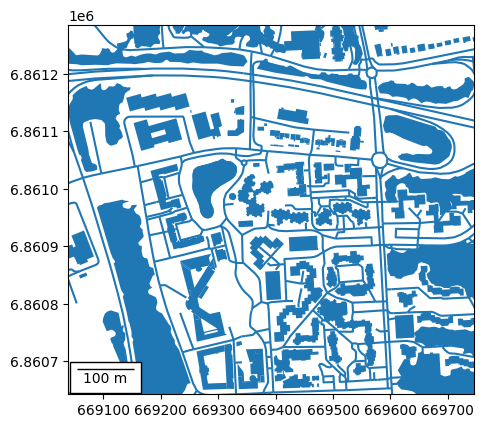

In [4]:
# Plotting the datas without setting up symbolization

ax = datas['gdf_trainline'].plot()
plt.xlim(669039, 669745)
plt.ylim(6860642, 6861286)	

scalebar = AnchoredSizeBar(ax.transData,
                           100,  
                           '100 m',  
                           'lower left',  
                           pad=0.5,
                           color='black',
                           frameon=True,
                           size_vertical=1)
ax.add_artist(scalebar)

for name, gdf in tqdm(datas.items(), desc = "displaying data layers : "):
    gdf.plot(ax = ax)

💬 This Notebook is meant to be **interactive** (beyond code modifications) : after **running** a code cell, you will often be able to **change** algorithm parameters or figure settings, thanks to **buttons**. Let's try interactivity on **road symbology**. You will be able to change roads **color** and **width** depending on their 'importance' attribute. You can also change the **size** of the figure (figure size button) and **revert** your changes.

**1.1.3/** Interactively setting up symbolization for roads

In [8]:
# Interactively setting up symbolization for roads
size = {'small':(5,5),'medium':(10,10), 'large':(15,15)}
roads_sorted = [] # Creation of a list containing a gdf by degree of road importance 
for i in range(2,len(datas['gdf_road'].importance.unique())+2):
    roads_sorted.append(datas['gdf_road'][(datas['gdf_road'].importance == str(i))]) 

grid = ipywidgets.GridspecLayout(5, 6)
grid[0,0] = ipywidgets.ColorPicker(concise=False,description='col_2',value='#ffffff')
grid[1,0] = ipywidgets.ColorPicker(concise=False,description='col_3',value='#ffffff')
grid[2,0] = ipywidgets.ColorPicker(concise=False,description='col_4',value='#ffffff')
grid[3,0] = ipywidgets.ColorPicker(concise=False,description='col_5',value='#ffffff')
grid[4,0] = ipywidgets.ColorPicker(concise=False,description='col_6',value='#ffffff')
grid[0,1] = ipywidgets.FloatSlider(min=0.6, max=5.0, step=0.2, description='width_2', continuous_update=False)
grid[1,1] = ipywidgets.FloatSlider(min=0.6, max=5.0, step=0.2, description='width_3', continuous_update=False)
grid[2,1] = ipywidgets.FloatSlider(min=0.6, max=5.0, step=0.2, description='width_4', continuous_update=False)
grid[3,1] = ipywidgets.FloatSlider(min=0.6, max=5.0, step=0.2, description='width_5', continuous_update=False)
grid[4,1] = ipywidgets.FloatSlider(min=0.6, max=5.0, step=0.2, description='width_6', continuous_update=False)
grid[0,2] = ipywidgets.Dropdown(options=['small','medium', 'large'], value='medium', description='figure_size')
grid[1,2] = ipywidgets.Button(description='revert',icon='undo')

def plt_roads(col_2, col_3, col_4, col_5, col_6, width_2, width_3, width_4, width_5, width_6, figure_size = 'medium'): # Function that plot each road and prepare arguments for interaction
    global size
    
    ax = datas['gdf_road'].plot(alpha = 0,figsize=size[figure_size])
    plt.xlim(669039, 669745)
    plt.ylim(6860642, 6861286)
    scalebar = AnchoredSizeBar(ax.transData,
                           100,  
                           '100 m',  
                           'lower left',  
                           pad=0.5,
                           color='black',
                           frameon=True,
                           size_vertical=1)
    ax.axes.get_yaxis().set_visible(False)

    list_col = [col_2, col_3, col_4, col_5, col_6]
    list_width = [width_2, width_3, width_4, width_5, width_6]

    for i in tqdm(reversed(range(2,len(datas['gdf_road'].importance.unique())+2)), desc = "changing symbology : ", ncols = 500,total = 5):
        roads_sorted[i-2].plot(ax = ax, color = "black", linewidth = list_width[i-2]+1,alpha = 0.5) 
        roads_sorted[i-2].plot(ax = ax, color = list_col[i-2], linewidth = list_width[i-2])

    def reset(b):
        grid[0,0].value = '#ffffff'
        grid[1,0].value = '#ffffff'
        grid[2,0].value = '#ffffff'
        grid[3,0].value = '#ffffff'
        grid[4,0].value = '#ffffff'
        grid[0,1].value = 0.6
        grid[1,1].value = 0.6
        grid[2,1].value = 0.6
        grid[3,1].value = 0.6
        grid[4,1].value = 0.6

    grid[1,2].on_click(reset)        

out_road_symbo = ipywidgets.interactive_output(plt_roads, {'col_2':grid[0,0], 'col_3':grid[1,0], 'col_4':grid[2,0], 'col_5':grid[3,0], 
'col_6':grid[4,0], 'width_2':grid[0,1], 'width_3':grid[1,1], 'width_4':grid[2,1], 'width_5':grid[3,1], 'width_6':grid[4,1], 'figure_size':grid[0,2]})# Calls up the function for interactively defining road width and color 

display(grid,out_road_symbo)

GridspecLayout(children=(ColorPicker(value='#ffffff', description='col_2', layout=Layout(grid_area='widget001'…

Output()

💬 Since there's **a lot** of symbolization functionality to configure, let's **fast-forward** and see what our **example basemap** might look like :

**1.1.4/** Display example basemap with symbology

displaying data layers :   0%|          | 0/5 [00:00<?, ?it/s]

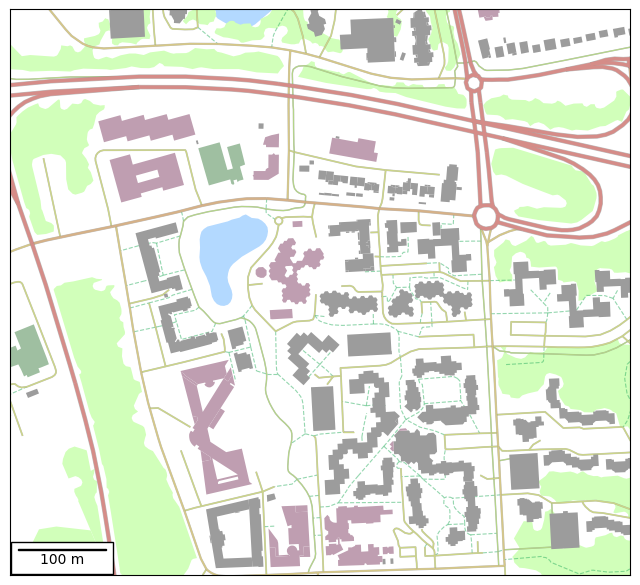

In [7]:
# Displaying example basemap with symbology

# Dividing roads according to their type and importance
roads_sorted = []
for i in range(2,len(datas['gdf_road'].importance.unique())+2):
    roads_sorted.append(datas['gdf_road'][(datas['gdf_road'].importance == str(i)) & (datas['gdf_road'].nature != "Chemin") 
                                                                    & (datas['gdf_road'].nature != "Sentier") 
                                                                    & (datas['gdf_road'].nature != "Route empierrée")]) 

gdf_paths = datas['gdf_road'][(datas['gdf_road'].nature == "Chemin") | (datas['gdf_road'].nature == "Sentier") # Creation of a gdf containing paths/trail
                                                         | (datas['gdf_road'].nature == "Route empierrée")] 

# Preparing color palettes for roads and buildings
list_col_roads = ['#d58c88','#d5b188','#d5c788','#ccd588','#b4d588','#95d588']
col_buildings = matcol.LinearSegmentedColormap.from_list('ColBuildings',
                                                        ['#9c9c9c','#9c9c9c','#bf9eb1','#9c9c9c','#fff3b0','#9c9c9c','#9c9c9c','#9fbfa1'])

# Setting up the map
ax = datas['gdf_road'].plot(alpha = 0, figsize=(8,8))
plt.xlim(669039, 669745)
plt.ylim(6860642, 6861286)	
scalebar = AnchoredSizeBar(ax.transData,
                           100,  
                           '100 m',  
                           'lower left',  
                           pad=0.5,
                           color='black',
                           frameon=True,
                           size_vertical=1)
ax.add_artist(scalebar)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

# Displaying the different features
pbar = tqdm(range(5), total = 5, desc = "displaying data layers : ")
for i in range(1):
        datas['gdf_water1'].plot(ax = ax, color = "#b3d9ff", zorder = 0) 
        sleep(0.1)
        pbar.update(1.0)
        gdf_paths.plot(ax =ax, color = "#2aae5f", linewidth = 0.8, linestyle='dashed', alpha = 0.5)
        sleep(0.1)
        pbar.update(1.0)
        for i in reversed(range(2,len(datas['gdf_road'].importance.unique())+2)): 
                roads_sorted[i-2].plot(ax = ax, color = "grey", linewidth = 6.5/i ,alpha = 0.5) 
                roads_sorted[i-2].plot(ax = ax, color = list_col_roads[i-2], linewidth = 5/i)
        sleep(0.1)
        pbar.update(1.0)
        datas['gdf_building'].plot(ax = ax, cmap = col_buildings, column = "usage_1", zorder = 2) 
        sleep(0.1)
        pbar.update(1.0)
        datas['gdf_vegetation'].plot(ax = ax, color = "#d1ffba", zorder = 0)
        sleep(0.1)
        pbar.update(1.0)
pbar.close()

💬 As you can see, by configuring the **symbolization** of our map's elements, we obtain a satisfactory basemap. 

However, the **legibility** of the map tends to **diminish** as the scale decreases (and the number of elements displayed increases)...

**Note :** This basemap could be improved by adding effects to the elements, such as **shading**. 
It should be noted that GIS environment offers more **user-friendly** tools for carrying out symbolization processes. 

### **1.2/** The issue of scale 
BD TOPO contains **many** different elements. As the scale (i.e. the mathematical relationship between the size of features on the map and reality) **decreases**, the number of features displayed **increases**. Sometimes there's too much information on the map. Here's an example :  

![Alt text](https://raw.githubusercontent.com/gowestmen/images/main/bd_topo_seine_et_marne.png)


Here we've displayed the BD TOPO at a **regional scale** without configuring the symbology. The result is **not readable**. The processes of transforming a map to make it readable are called **map generalization**. They can be carried out in different ways:
- by **selecting** the elements to be displayed
- parameterizing **symbology** (reducing road width, for example)
- by performing **transformations on the entities** themselves -> that is what CartAGen is made for ! 

Let's make the same basemap on a **smaller scale**, to see to what extent entity selection and symbology settings are sometimes **not enough** to get a good result.

**1.2.1/** Importing the data of the second extract 

In [3]:
# Importing the data of the second extract 

files = os.listdir('data/data_fd_carte_2')

layer_names_2 = []
layer_list_2 = []

pbar = tqdm(files,total = 10, desc = "charging second data extract")
for file in files:
    data = gp.read_file(f'data/data_fd_carte_2/{file}')
    layer_list_2.append(data)
    match = re.match(r'^(.*)\.geojson', file)
    layer_names_2.append(match.group(1))
    sleep(0.1)
    pbar.update(1.0)
pbar.close()
datas_2 = {name: gdf for name, gdf in zip(layer_names_2, layer_list_2)}

if len(layer_list_2) == len(os.listdir('data/data_fd_carte_2')):
    print("✅ successful import")
else:
    print("❌ import failed")

charging second data extract:   0%|          | 0/10 [00:00<?, ?it/s]

✅ successful import


**1.2.2/** Display the smaller scale base map

displaying data layers :   0%|          | 0/11 [00:00<?, ?it/s]

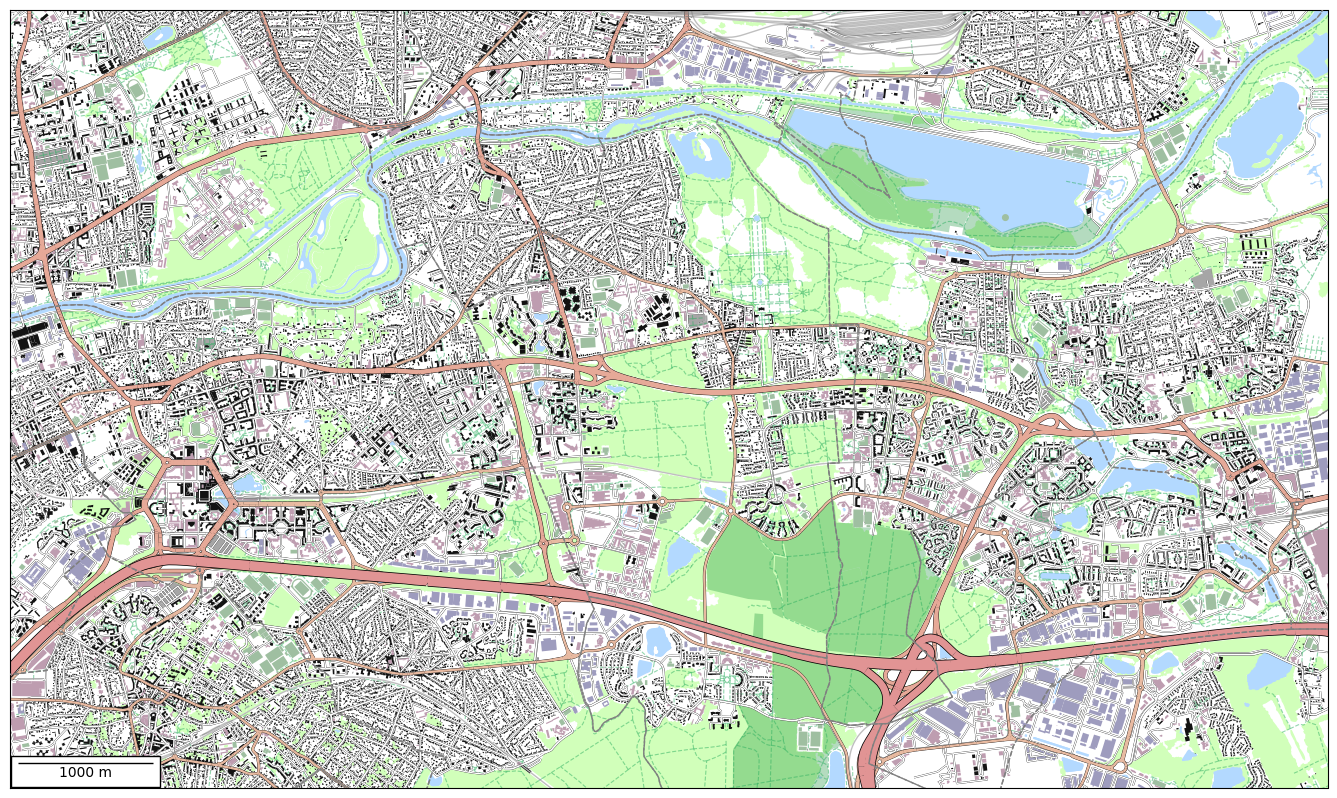

In [4]:
# Dividing roads according to their type and importance
gdf_roads_2 = []
for i in range(1,len(datas_2['gdf_road'].importance.unique())+2):
    gdf_roads_2.append(datas_2['gdf_road'][(datas_2['gdf_road'].importance == str(i)) & (datas_2['gdf_road'].nature != "Chemin") 
                                                                    & (datas_2['gdf_road'].nature != "Sentier") 
                                                                    & (datas_2['gdf_road'].nature != "Route empierrée")])      
gdf_paths_2 = datas_2['gdf_road'][(datas_2['gdf_road'].nature == "Chemin") | (datas_2['gdf_road'].nature == "Sentier") # Creation of a gdf containing paths/trail
                                                         | (datas_2['gdf_road'].nature == "Route empierrée")] 

# Preparing color palettes for roads and buildings
list_col_roads = ['#e19494','#e6a998','#e8baa1','#ffffff','#ffffff','#ffffff']
col_buildings = matcol.LinearSegmentedColormap.from_list('ColBuildings',
                                                        ['#111111','#111111','#bf9eb1','#111111','#9f9dbf','#111111','#111111','#9fbfa1'])

# Setting up the map
ax = datas_2['gdf_road'].plot(alpha = 0, figsize = (17,17))
plt.xlim(665361, 675157)
plt.ylim(6858025, 6863813)	
scalebar = AnchoredSizeBar(ax.transData,
                           1000,  
                           '1000 m',  
                           'lower left',  
                           pad=0.5,
                           color='black',
                           frameon=True,
                           size_vertical=1)
ax.add_artist(scalebar)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

# Displaying the different features
pbar = tqdm(range(11), total = 11, desc = "displaying data layers : ")
for i in range(1):
        datas_2['gdf_water1'].plot(ax = ax, color = "#b3d9ff", zorder = 0) 
        sleep(0.1)
        pbar.update(1)
        datas_2['gdf_water2'].plot(ax = ax, color = "#b3d9ff", zorder = 0) 
        sleep(0.1)
        pbar.update(1)
        gdf_paths_2.plot(ax =ax, color = "#2aae5f", linewidth = 0.8, linestyle='dashed', alpha = 0.5) 
        sleep(0.1)
        pbar.update(1)
        datas_2['gdf_building'].plot(ax = ax, cmap = col_buildings, column = "usage_1", zorder = 2) 
        sleep(0.1)
        pbar.update(1)
        for i in reversed(range(1,len(datas_2['gdf_road'].importance.unique())+1)): 
                gdf_roads_2[i-1].plot(ax = ax, color = "black", linewidth = 6.2/i) 
                gdf_roads_2[i-1].plot(ax = ax, color = list_col_roads[i-1], linewidth = 5.1/i)
        sleep(0.1)
        pbar.update(1)       
        datas_2['gdf_vegetation'].plot(ax = ax, color = "#d1ffba", zorder = 0) 
        sleep(0.1)
        pbar.update(1)
        datas_2['gdf_forest'].plot(ax = ax, color = "#098a2e", zorder = 0, alpha = 0.3) 
        sleep(0.1)
        pbar.update(1)
        datas_2['gdf_commune'].plot(ax = ax, facecolor = "None", edgecolor = "grey", linestyle='dashed', zorder = 3) 
        sleep(0.1)
        pbar.update(1)
        datas_2['gdf_trainline'].plot(ax = ax, color = "grey", linewidth = 1, alpha = 0.5) 
        sleep(0.1)
        pbar.update(1)
        datas_2['gdf_sportfield'].plot(ax = ax, color = "#9fbfa1") 
        sleep(0.1)
        pbar.update(1)
        datas_2['gdf_graveyard'].plot(ax = ax, color = "grey", alpha = 0.7) 
        sleep(0.1)
        pbar.update(1)
pbar.close()

💬 This map shows elements of the BD TOPO at **1:25000** scale (approximatly). Compared with our first basemap, there are **much** more elements displayed. In addition, the map's legibility is **altered**, especially with regard to the following aspects : 
- many buildings (especially houses) are **too small** and produce **noise** in map legibility
- some roads, especially paths, are **too complex in shape**, so that they look more like a mass than a line

To solve these **problems**, it's not enough to modify the **symbology** or to **select** the elements to be represented. Let's take the example of paths :
- we can't really improve legibility by changing the symbology, since the **path width** is already quite small
- not displaying paths at all seems like a bad solution (depending on cartographer's needs), as they provide **useful landmarks** on the map, especially in forests.

➡️ To enhance our base map, we need to perform **transformations** on the features. Let's use CartAGen to build a cartographic generalization **workflow** !



## 🏗 **Part 2 :** Cartographic generalisation workflow for basemap creation

💬 As mentioned above, the **needs** for cartographic generalization depend on the **scale** of the intended rendering (and therefore the number of elements displayed).  
But these needs also depend on the map's **objectives**. For example, if cartographers want to display a lot of **thematic datas** on their basemap, it's in their interest to use one with a **minimalist** appearance, to stylize their map without detracting from the legibility of the thematic datas.

In other words, there isn't just one "good" generalization workflow for a given result, but several, depending on the **needs and subjectivity** of the cartographers.

Thus, this section will present different **workflows** for cartographic generalization, leading to **more or less** generalized results. 

As some map generalization algorithms can be **quite long** to run (especially on buildings), we will present our results on a **small area** in this Notebook, in order to keep loading time acceptable.

### **2.1/** Selection and symbolization
💬 Let's start by **selecting** the elements we want to display and setting up the desired **symbology** - the **first steps** in a cartographic generalization process.

Depending on the **level of generalization** you wish to achieve, your choices in terms of selection and symbolization will **change** :
- highly generalized : keep only the **main elements** and set a **wide** width for linear elements
- slightly generalized : retain **most elements** and set a **narrow** width for linear elements

**2.1.1/** Import and prepare third data extract

In [5]:
# Import and prepare third data extract
files = os.listdir('data/data_fd_carte_3')
layer_names_3 = []

layer_list_3 = []
for file in tqdm(files,desc = "charging third data extract : "): # Loading data files
    data = gp.read_file(f'data/data_fd_carte_3/{file}')
    layer_list_3.append(data)
    match = re.match(r'^(.*)\.geojson', file)
    layer_names_3.append(match.group(1))

datas_3 = {name: gdf for name, gdf in zip(layer_names_3, layer_list_3)} # Storing datas in a dictionary

def multipolygon_to_polygon(geom): # function that transform MultiPolygon geometry to Polygon
    if isinstance(geom, MultiPolygon):
        return geom.geoms[0]
    return geom

for gdf in datas_3: # Only keep useful columns and perform geometry transformations
    if 'usage_1' in datas_3[gdf].columns:
        datas_3[gdf] = datas_3[gdf][["cleabs","usage_1","geometry"]]
        datas_3[gdf].loc[:,"geometry"] = datas_3[gdf].loc[:,"geometry"].apply(multipolygon_to_polygon)
        datas_3[gdf].loc[:,"geometry"] = datas_3[gdf].loc[:,"geometry"].force_2d()
        
    elif 'nature' in datas_3[gdf].columns and 'importance' in datas_3[gdf].columns:
        datas_3[gdf] = datas_3[gdf][["cleabs","nature","importance","geometry"]]
        datas_3[gdf].loc[:,"geometry"] = datas_3[gdf].loc[:,"geometry"].force_2d()
        
    else:
        if datas_3[gdf].geometry[0].geom_type != 'LineString' :
            datas_3[gdf] = datas_3[gdf][["cleabs","geometry"]]
            datas_3[gdf].loc[:,"geometry"] = datas_3[gdf].loc[:,"geometry"].apply(multipolygon_to_polygon)
            datas_3[gdf].loc[:,"geometry"] = datas_3[gdf].loc[:,"geometry"].force_2d()
        else:
            datas_3[gdf] = datas_3[gdf][["cleabs","geometry"]]
            datas_3[gdf].loc[:,"geometry"] = datas_3[gdf].loc[:,"geometry"].force_2d()

if len(layer_list_3) == len(os.listdir('data/data_fd_carte_3')): # Print success/failure message
    print("✅ successful import")
else:
    print("❌ import failed")

charging third data extract :   0%|          | 0/7 [00:00<?, ?it/s]

✅ successful import


**2.1.2/** Select elements to display

In [6]:
# Select elements to display
grid = ipywidgets.GridspecLayout(7, 8) # Creating grid layout for our buttons

ROAD_TYPE = {
    '0':'one_side_road',
    '1':'two_side_road',
    '2':'roundabout',
    '3':'trail',
    '4':'rocky_road'}
ROAD_TYPE_FR = {
    '0':'Route à 1 chaussée',
    '1':'Route à 2 chaussées',
    '2':'Rond-point',
    '3':'Sentier',
    '4':'Route empierrée'}
BUILDING_TYPE = {
    '0':'residential',
    '1':'annex',
    '2':'commercial and services',
    '3':'religious',
    '4':'agricultural',
    '5':'sport facility',
    '6':'other'}
BUILDING_TYPE_FR = {
    '0':'Résidentiel',
    '1':'Annexe',
    '2':'Commercial et services',
    '3':'Religieux',
    '4':'Agricole',
    '5':'Sportif',
    '6':'Indifférencié'}

for i in range(5): # buttons for road selection according to importance level and type
    grid[i,0] = ipywidgets.Checkbox(value=True, description=f"road_importance_{i+2}")
    grid[i,1] = ipywidgets.Checkbox(value=True, description=ROAD_TYPE[f"{i}"])  
for i in range(7): # buttons for building selection according to type
    grid[i,2] = ipywidgets.Checkbox(value=True, description=BUILDING_TYPE[f"{i}"])
for i in range(1): # buttons for other features
    grid[0,3] = ipywidgets.Checkbox(value=True, description='communes_boundaries')
    grid[0,4] = ipywidgets.Checkbox(value=True, description='sports_field')
    grid[0,5] = ipywidgets.Checkbox(value=True, description='trainline')
    grid[0,6] = ipywidgets.Checkbox(value=True, description='vegetation_zone')
    grid[0,7] = ipywidgets.Checkbox(value=True, description='water')
    grid[3,3] = ipywidgets.Dropdown(options=['1:25000','1:10000', '1:7500', '1:5000'], value='1:7500', description='scale')

selected_data = 0 # Declaring the variable that will store the selected datas

def plt_and_select(road_importance_2,road_importance_3,road_importance_4,road_importance_5,road_importance_6,
                   one_side_road, two_side_road, roundabout, trail, rocky_road, 
                   residential, annex, commercial_services, religious, agricultural, sport_facility, other,
                   communes_boundaries,
                   sports_field,
                   trainline,
                   vegetation_zone,
                   water,scale):
    # Setting up the map
    global SCREEN
    global list_generalized
    fig = plt.figure(figsize=SCREEN[scale])
    ax = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)	
    scalebar = AnchoredSizeBar(ax.transData,
                           250,  
                           '250 m',  
                           'lower left',  
                           pad=0.5,
                           color='black',
                           frameon=True,
                           size_vertical=1)
    ax.add_artist(scalebar)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    global selected_data
    selected_data = datas_3.copy()
    
    for i in range(1): # Filtering storage variable on interactively selected features
        if road_importance_2 != True:          
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].importance != "2")]
        
        if road_importance_3 != True:
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].importance != "3")]

        if road_importance_4 != True:
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].importance != "4")]

        if road_importance_5 != True:
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].importance != "5")]

        if road_importance_6 != True:
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].importance != "6")]

        if one_side_road != True:
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].nature != "Route à 1 chaussée")]

        if two_side_road != True:
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].nature != "Route à 2 chaussées")]

        if roundabout != True:
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].nature != "Rond-point")]

        if trail != True:
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].nature != "Sentier")]

        if rocky_road != True:
            selected_data['gdf_road'] = selected_data['gdf_road'][(selected_data['gdf_road'].nature != "Route empierrée")]
        
        if residential != True:
            selected_data['gdf_building'] = selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 != "Résidentiel")]

        if annex != True:
            selected_data['gdf_building'] = selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 != "Annexe")]

        if commercial_services != True:
            selected_data['gdf_building'] = selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 != "Commercial et services")]

        if religious != True:
            selected_data['gdf_building'] = selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 != "Religieux")]

        if agricultural != True:
            selected_data['gdf_building'] = selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 != "Agricole")]

        if sport_facility != True:
            selected_data['gdf_building'] = selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 != "Sportif")]

        if other != True:
            selected_data['gdf_building'] = selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 != "Indifférencié")]

        if communes_boundaries != False:
            selected_data['gdf_commune'].plot(ax= ax, facecolor = 'None', edgecolor = "grey")
        else:
            selected_data['gdf_commune'] = selected_data['gdf_commune'].iloc[0:0]

        if sports_field != False:
            selected_data['gdf_sportfield'].plot(ax= ax, facecolor = "red")
        else:
            selected_data['gdf_sportfield'] = selected_data['gdf_sportfield'].iloc[0:0]

        if trainline != False:
            selected_data['gdf_trainline'].plot(ax= ax, color = "black")
        else:
            selected_data['gdf_trainline'] = selected_data['gdf_trainline'].iloc[0:0]
        
        if vegetation_zone != False:
            selected_data['gdf_vegetation'].plot(ax= ax, facecolor = "green")
        else:
            selected_data['gdf_vegetation'] = selected_data['gdf_vegetation'].iloc[0:0]

        if water != False:
            selected_data['gdf_water'].plot(ax= ax, facecolor = "blue")
        else:
            selected_data['gdf_water'] = selected_data['gdf_water'].iloc[0:0]

    pbar = tqdm(range(17), total = 17, desc = "displaying data layers : ")
    for i in range(5): # Displaying roads
        selected_data['gdf_road'][(selected_data['gdf_road'].importance == f"{i+2}")].plot(ax = ax, color = "orange", linewidth = 4*(1/(i+1)))
        pbar.update(1.0)
        selected_data['gdf_road'][(selected_data['gdf_road'].nature == ROAD_TYPE_FR[f"{i}"])].plot(ax = ax, color = "orange", linewidth = 0.5)
        pbar.update(1.0)   
    for i in range(7): # Displaying buildings
        selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == BUILDING_TYPE_FR[f"{i}"])].plot(ax = ax, color = list(np.random.choice(range(256), size=3)/256))
        pbar.update(1.0)
    pbar.close()
    list_generalized = [selected_data['gdf_road'].copy()]
out = ipywidgets.interactive_output(plt_and_select, {'road_importance_2':grid[0,0],'road_importance_3':grid[1,0], 'road_importance_4':grid[2,0], 'road_importance_5':grid[3,0], 'road_importance_6':grid[4,0],
                                                     'one_side_road':grid[0,1],'two_side_road':grid[1,1], 'roundabout':grid[2,1], 'trail':grid[3,1], 'rocky_road':grid[4,1],
                                                     'residential':grid[0,2],'annex':grid[1,2],'commercial_services':grid[2,2],'religious':grid[3,2],'agricultural':grid[4,2],'sport_facility':grid[5,2],'other':grid[6,2],
                                                     'communes_boundaries':grid[0,3],
                                                     'sports_field':grid[0,4],
                                                     'trainline':grid[0,5],
                                                     'vegetation_zone':grid[0,6],
                                                     'water':grid[0,7],
                                                     'scale':grid[3,3]})   
display(grid, out)

GridspecLayout(children=(Checkbox(value=True, description='road_importance_2', layout=Layout(grid_area='widget…

Output()

**2.1.3/** Set up symbology

In [7]:
# Set up symbology
gdf_bckgrnd = gp.GeoDataFrame(geometry=gp.GeoSeries([loads('Polygon ((668199 6860870, 669412 6860870, 669412 6860148, 668199 6860148, 668199 6860870))')]))

grid = ipywidgets.GridspecLayout(7, 9) # Creating grid layout for our button

for i in range(5): # Creating the buttons road color and width
    grid[i,0] = ipywidgets.ColorPicker(concise=False,description=f"col_road_{i+2}",value='#111111')
    grid[i,1] = ipywidgets.FloatSlider(min=0.6, max=15.0, step=0.2, description=f'width_road_{i+2}', continuous_update=False,style= {'description_width': 'initial'})
for i in range(7): # Creating the buildings color
    grid[i,2] = ipywidgets.ColorPicker(concise=False,description='col_'+BUILDING_TYPE[f'{i}'],value='#111111',style= {'description_width': 'initial'})
for i in range(1): # buttons for other features
    grid[0,3] = ipywidgets.Checkbox(value=True, description='background_on_off')
    grid[1,3] = ipywidgets.ColorPicker(concise=False, description='col_bckgrnd', value='#ffffff')
    grid[4,3] = ipywidgets.Dropdown(options=['1:25000','1:10000', '1:7500', '1:5000'], value='1:7500', description='scale')

    grid[0,4] = ipywidgets.ColorPicker(concise=False, description='col_sports_field', value='#111111',style= {'description_width': 'initial'})

    grid[0,5] = ipywidgets.ColorPicker(concise=False, description='col_communes', value='#111111', style= {'description_width': 'initial'})
    grid[1,5] = ipywidgets.FloatSlider(min=0.6, max=15.0, step=0.2, description='width_communes', continuous_update=False, style= {'description_width': 'initial'})

    grid[0,6] = ipywidgets.ColorPicker(concise=False, description='col_trainline', value='#111111')
    grid[1,6] = ipywidgets.FloatSlider(min=0.6, max=15.0, step=0.2, description='width_trainline', continuous_update=False, style= {'description_width': 'initial'})

    grid[0,7] = ipywidgets.ColorPicker(concise=False, description='col_vegetation', value='#111111')

    grid[0,8] = ipywidgets.ColorPicker(concise=False, description='col_water', value='#111111')

    SYMBO_PARAM = { # Declare variable that will store chosen values
        'road_col_2':'0',
        'road_col_3':'0',
        'road_col_4':'0',
        'road_col_5':'0',
        'road_col_6':'0',
        'road_width_2':0,
        'road_width_3':0,
        'road_width_4':0,
        'road_width_5':0,
        'road_width_6':0,  
        'residential_col' :'0',
        'annex_col' :'0',
        'com_serv_col' :'0',
        'religious_col' :'0',
        'agricultural_col' :'0',
        'sport_facility_col' :'0',
        'other_col' :'0',
        'bckgrnd_col' :'0',
        'sports_field_col' :'0',
        'communes_col' :'0',
        'communes_width' :'0',
        'trainline_col' :'0',
        'trainline_width' :'0',
        'vegetation_col' :'0',
        'water_col' :'0'}

def pick_symbo(col_road_2, col_road_3, col_road_4, col_road_5, col_road_6, # Function for interactively set up symbology
               width_road_2, width_road_3, width_road_4, width_road_5, width_road_6, 
               col_residential, col_annex, col_com_serv, col_religious, col_agricultural, col_sport_facility, col_other, 
               background_on_off, col_bckgrnd,
               col_sports_field,
               col_communes, width_communes,
               col_trainline, width_trainline,
               col_vegetation,
               col_water,
               scale):

    # Setting up the map
    global SCREEN          
    fig = plt.figure(figsize=SCREEN[scale])
    ax = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)	
    scalebar = AnchoredSizeBar(ax.transData,
                           250,  
                           '250 m',  
                           'lower left',  
                           pad=0.5,
                           color='black',
                           frameon=True,
                           size_vertical=1)
    ax.add_artist(scalebar)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    global SYMBO_PARAM # Calling the dictionnary that will store parameters

    pbar = tqdm(range(18), total = 18, desc = "changing symbology : ")
    for i in range(1):
        if grid[0,3].value == True:
            gdf_bckgrnd.plot(ax= ax, color = col_bckgrnd)
            SYMBO_PARAM['bckgrnd_col'] = grid[1,3].value
            grid[1,3].description = "col_bckgrnd"
        else:
            grid[1,3].description = "not selected"
        pbar.update(1.0)  

        if not selected_data['gdf_vegetation'].empty:
            selected_data['gdf_vegetation'].plot(ax= ax, color = col_vegetation)
            SYMBO_PARAM['vegetation_col'] = grid[0,7].value
        else:
            grid[0,7].description = "not selected"
        pbar.update(1.0)  

        if not selected_data['gdf_road'][(selected_data['gdf_road'].importance == "6")].empty:
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == "6")].plot(ax= ax, color = "#1f2232", linewidth = width_road_6+1, alpha = 0.5)
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == "6")].plot(ax= ax, color = col_road_6, linewidth = width_road_6)
            SYMBO_PARAM['road_col_6'] = grid[4,0].value
            SYMBO_PARAM['road_width_6'] = grid[4,1].value
        else:
            grid[4,0].description = "not selected"
            grid[4,1].description = "not selected"
        pbar.update(1.0)  

        if not selected_data['gdf_road'][(selected_data['gdf_road'].importance == "5")].empty:
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == "5")].plot(ax= ax, color = "#1f2232", linewidth = width_road_5+1, alpha = 0.5)
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == "5")].plot(ax= ax, color = col_road_5, linewidth = width_road_5)
            SYMBO_PARAM['road_col_5'] = grid[3,0].value
            SYMBO_PARAM['road_width_5'] = grid[3,1].value
        else:
            grid[3,0].description = "not selected"
            grid[3,1].description = "not selected"
        pbar.update(1.0)  

        if not selected_data['gdf_road'][(selected_data['gdf_road'].importance == "4")].empty:
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == "4")].plot(ax= ax, color = "#1f2232", linewidth = width_road_4+1, alpha = 0.5)
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == "4")].plot(ax= ax, color = col_road_4, linewidth = width_road_4)
            SYMBO_PARAM['road_col_4'] = grid[2,0].value
            SYMBO_PARAM['road_width_4'] = grid[2,1].value
        else:
            grid[2,0].description = "not selected"
            grid[2,1].description = "not selected"
        pbar.update(1.0)   

        if not selected_data['gdf_road'][(selected_data['gdf_road'].importance == "3")].empty:
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == "3")].plot(ax= ax, color = "#1f2232", linewidth = width_road_3+1, alpha = 0.5)
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == "3")].plot(ax= ax, color = col_road_3, linewidth = width_road_3)
            SYMBO_PARAM['road_col_3'] = grid[1,0].value
            SYMBO_PARAM['road_width_3'] = grid[1,1].value
        else:
            grid[1,0].description = "not selected"
            grid[1,1].description = "not selected"
        pbar.update(1.0)     

        if not selected_data['gdf_road'][(selected_data['gdf_road'].importance == "2")].empty:
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == "2")].plot(ax= ax, color = "#1f2232", linewidth = width_road_2+1, alpha = 0.5)
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == "2")].plot(ax= ax, color = col_road_2, linewidth = width_road_2)
            SYMBO_PARAM['road_col_2'] = grid[0,0].value
            SYMBO_PARAM['road_width_2'] = grid[0,1].value
        else:
            grid[0,0].description = "not selected"
            grid[0,1].description = "not selected"
        pbar.update(1.0)   

        if not selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Résidentiel")].empty:
            selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Résidentiel")].plot(ax= ax, color = col_residential)
            SYMBO_PARAM['residential_col'] = grid[0,2].value
        else:
            grid[0,2].description = "not selected"
        pbar.update(1.0)  

        if not selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Annexe")].empty:
            selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Annexe")].plot(ax= ax, color = col_annex)
            SYMBO_PARAM['annex_col'] = grid[1,2].value
        else:
            grid[1,2].description = "not selected"
        pbar.update(1.0)  

        if not selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Commercial et services")].empty:
            selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Commercial et services")].plot(ax= ax, color = col_com_serv)
            SYMBO_PARAM['com_serv_col'] = grid[2,2].value
        else:
            grid[2,2].description = "not selected"
        pbar.update(1.0)  

        if not selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Religieux")].empty:
            selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Religieux")].plot(ax= ax, color = col_religious)
            SYMBO_PARAM['religious_col'] = grid[3,2].value
        else:
            grid[3,2].description = "not selected"
        pbar.update(1.0)  

        if not selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Agricole")].empty:
            selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Agricole")].plot(ax= ax, color = col_agricultural)
            SYMBO_PARAM['agricultural_col'] = grid[4,2].value
        else:
            grid[4,2].description = "not selected"
        pbar.update(1.0)  

        if not selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Sportif")].empty:
            selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Sportif")].plot(ax= ax, color = col_sport_facility)
            SYMBO_PARAM['sport_facility_col'] = grid[5,2].value
        else:
            grid[5,2].description = "not selected"
        pbar.update(1.0)  

        if not selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Indifférencié")].empty:
            selected_data['gdf_building'][(selected_data['gdf_building'].usage_1 == "Indifférencié")].plot(ax= ax, color = col_other)
            SYMBO_PARAM['other_col'] = grid[6,2].value
        else:
            grid[6,2].description = "not selected"
        pbar.update(1.0)      

        if not selected_data['gdf_sportfield'].empty:
            selected_data['gdf_sportfield'].plot(ax= ax, color = col_sports_field)
            SYMBO_PARAM['sports_field_col'] = grid[0,4].value
        else:
            grid[0,4].description = "not selected"
        pbar.update(1.0)  

        if not selected_data['gdf_commune'].empty:
            selected_data['gdf_commune'].plot(ax= ax, facecolor = 'None', edgecolor = col_communes, linewidth = width_communes,linestyle='dashed', alpha = 0.25)
            SYMBO_PARAM['communes_col'] = grid[0,5].value
            SYMBO_PARAM['communes_width'] = grid[1,5].value
        else:
            grid[0,5].description = "not selected"
            grid[1,5].description = "not selected"
        pbar.update(1.0)  

        if not selected_data['gdf_trainline'].empty:
            selected_data['gdf_trainline'].plot(ax= ax, color = col_trainline, linewidth = width_trainline)
            SYMBO_PARAM['trainline_col'] = grid[0,6].value
            SYMBO_PARAM['trainline_width'] = grid[1,6].value
        else:
            grid[0,6].description = "not selected"
            grid[1,6].description = "not selected"
        pbar.update(1.0)  

        if not selected_data['gdf_water'].empty:
            selected_data['gdf_water'].plot(ax= ax, color = col_water)
            SYMBO_PARAM['water_col'] = grid[0,8].value
        else:
            grid[0,8].description = "not selected"
        pbar.update(1.0) 
    pbar.close()

out_2 = ipywidgets.interactive_output(pick_symbo,{'col_road_2':grid[0,0],'col_road_3':grid[1,0],'col_road_4':grid[2,0],'col_road_5':grid[3,0], 'col_road_6':grid[4,0],
                                                  'width_road_2':grid[0,1],'width_road_3':grid[1,1],'width_road_4':grid[2,1],'width_road_5':grid[3,1],'width_road_6':grid[4,1],
                                                  'col_residential':grid[0,2], 'col_annex':grid[1,2], 'col_com_serv':grid[2,2], 'col_religious':grid[3,2], 'col_agricultural':grid[4,2], 'col_sport_facility':grid[5,2], 'col_other':grid[6,2],
                                                  'background_on_off':grid[0,3], 'col_bckgrnd':grid[1,3],
                                                  'col_sports_field':grid[0,4],
                                                  'col_communes':grid[0,5], 'width_communes':grid[1,5],
                                                  'col_trainline':grid[0,6], 'width_trainline':grid[1,6],
                                                  'col_vegetation':grid[0,7],
                                                  'col_water':grid[0,8],
                                                  'scale':grid[4,3]})

display(grid, out_2)
scale = ipywidgets.Dropdown(options=['1:25000','1:10000', '1:7500', '1:5000'], value='1:7500', description='scale')

GridspecLayout(children=(ColorPicker(value='#111111', description='col_road_2', layout=Layout(grid_area='widge…

Output()

💬 Now that we have done the **selection and symbolization**, it's time to dive into the **transformation** of our elements to complete our generalization processes.

The following sections will present proposed workflows for three **levels of generalization**. If the code cell relates to the targeted generalization level (indicated by the 🟡, 🟠 or 🔴 icon), then you should **run** this cell, otherwise you can **skip** it and go the next code cell.

- 🟡 **Slightly generalized :** most map details are preserved -> useful for large-scale maps (neighborhood) 
- 🟠 **Medium generalization :** intermediate between very generalized and lightly generalized rendering.
- 🔴 **Very generalized :** only the main map structures are preserved -> useful for small scales or minimalist basemaps


### **2.2/** Road generalization

Let's start by generalizing roads and paths so they have less details

**2.2.1/** 🟡🟠🔴 Using the "detect_dead_ends" algorithm on roads, to select small sections that decreazes road network legibility

In [8]:
# 🟡🟠🔴 Step 1 : Using the "detect_dead_ends" algorithm on roads, to select small sections that decreazes road network legibility
de_col = matcol.LinearSegmentedColormap.from_list('de_col',['blue','red'])
count = -1
revert = ipywidgets.Button(description='revert',icon='undo')
outside_faces = ipywidgets.Checkbox(value=True, description="outside_faces")
scale = ipywidgets.Dropdown(options=['1:25000','1:10000', '1:7500', '1:5000'], value='1:7500', description='scale')

def plt_dtc_de(outside_faces, scale):
    global dead_ends
    global list_generalized
    global SCREEN
    global de_col
    global count 

    for i in tqdm(range(1)):
        try:
            dead_ends = c4.detect_dead_ends(list_generalized[count], outside_faces = outside_faces)
        except IndexError:
            count += 1
            dead_ends = c4.detect_dead_ends(list_generalized[count], outside_faces = outside_faces)

    # Setting up the map
    fig = plt.figure(figsize=SCREEN[scale])
    ax = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)		
    scalebar = AnchoredSizeBar(ax.transData, 250, '250 m', 'lower left', pad=0.5, color='black', frameon=True, size_vertical=1)
    ax.add_artist(scalebar)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    # Display the result 
    dead_ends.plot(ax = ax, column = 'deadend', cmap = de_col, linewidth = 0.8) 

def revert_fun(b):
    global count 
    global out_dtc_de
    count -= 1
    clear_output()
    out_dtc_de = ipywidgets.interactive(plt_dtc_de, outside_faces = outside_faces, scale = scale)
    display(out_dtc_de, revert)
revert.on_click(revert_fun)
 

out_dtc_de = ipywidgets.interactive(plt_dtc_de, outside_faces = outside_faces, scale = scale)
display(out_dtc_de, revert)

interactive(children=(Checkbox(value=False, description='outside_faces'), Dropdown(description='scale', index=…

Button(description='revert', icon='undo', style=ButtonStyle())

If you wish to see how the code of this algorithm works, press **`space bar`** and go to the next sub-slide.

**2.2.1'/** Detect dead end algorithm details

<Axes: >

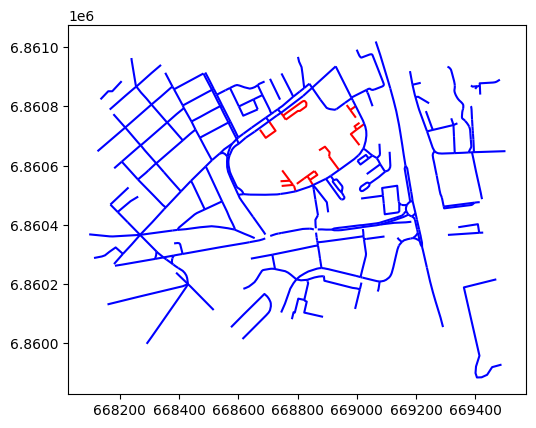

In [10]:
import cartagen4py as c4

de = c4.detect_dead_ends(list_generalized[count], outside_faces = False) #list_generalized[count] is the road network in Geopandas GeoDataFrame format

de_col = matcol.LinearSegmentedColormap.from_list('de_col',['blue','red']) #declaring color palette for displaying result
de.plot(column = 'deadend', cmap = de_col) #using .plot() method on given GeoDataFrame, 
# and set up color according to section status (i.e dead end = True or False)

💬 This algorithm detect dead ends on each **"faces"** of the road network, i.e every zones **delimitated by roads**. As our data sample is **small**, we have a lot of **outside faces**, which tends to detect sections as dead ends while they are **main roads** cut in this data extract. 

<Axes: >

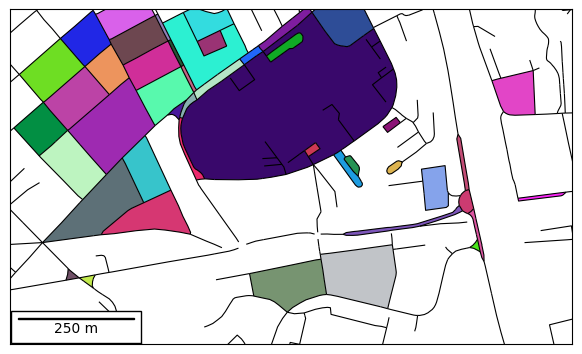

In [11]:
# Network faces calculation example
# Setting up the map
fig = plt.figure(figsize=SCREEN['1:7500'])
ax = fig.add_subplot(111)
plt.xlim(668198, 669411)
plt.ylim(6860147, 6860869)		
scalebar = AnchoredSizeBar(ax.transData,
                                    250,  
                                    '250 m',  
                                    'lower left',  
                                    pad=0.5,
                                    color='black',
                                    frameon=True,
                                    size_vertical=1)
ax.add_artist(scalebar)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

nf_geom = c4.network_faces(dead_ends.geometry,convex_hull=out_dtc_de.kwargs['outside_faces'])
nf = gp.GeoDataFrame(geometry=gp.GeoSeries(nf_geom))

list_col_face = []
for i in nf.geometry:
    list_col_face.append((np.random.uniform(0, 1),np.random.uniform(0, 1),np.random.uniform(0, 1)))

col_face = matcol.LinearSegmentedColormap.from_list('col_face',list_col_face)

nf.plot(ax=ax, cmap = col_face)
dead_ends.plot(ax=ax, color = 'black', linewidth = 0.8)

💬 Here is how are delimited the **network faces**. Only colorized part are faces taken in account for dead end **detection**

**2.2.2/** 🟡🟠🔴 Removing part of the roads considered as dead ends by using "eliminate_dead_ends" 

In [12]:
# 🟡🟠🔴 Step 2 : Removing part of the roads considered as dead ends by using "eliminate_dead_ends"
count_intrn = 0
def plt_elim_de(length, klongest, scale = "1:7500"):
    global list_generalized
    global dead_ends
    global SCREEN
    global de_col
    global count
    global count_intrn
    for i in tqdm(range(1)):
        if 'dead_ends' not in globals():
            print("you must perform dead ends detection before collapsing them !")
        else:
            count_intrn += 1
            if count_intrn > 1:
                del(list_generalized[-1])
            generalized = c4.eliminate_dead_ends(dead_ends, length, klongest)
            list_generalized.append(generalized)
            
            # Setting up the map
            fig = plt.figure(figsize=SCREEN[scale])
            ax = fig.add_subplot(111)
            plt.xlim(668198, 669411)
            plt.ylim(6860147, 6860869)		
            scalebar = AnchoredSizeBar(ax.transData,
                                            250,  
                                            '250 m',  
                                            'lower left',  
                                            pad=0.5,
                                            color='black',
                                            frameon=True,
                                            size_vertical=1)
            ax.add_artist(scalebar)
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
                    
            list_generalized[-1].plot(ax =ax, column = 'deadend', cmap = de_col, linewidth = 0.8)

ipywidgets.interact(plt_elim_de, length = ipywidgets.FloatSlider(value = 20, min = 0,max = 500,step = 10,continuous_update=False),
                                                          klongest = True,
                                                          scale = ['1:25000','1:10000', '1:7500', '1:5000'])

interactive(children=(FloatSlider(value=20.0, continuous_update=False, description='length', max=500.0, step=1…

<function __main__.plt_elim_de(length, klongest, scale='1:7500')>

💬 You can configure the **length threshold** to keep part of the dead ends (if you need details on your map). Using the keep_longest button allows you to keep the **main component** of dead end section, when it has a complex shape.

**2.2.2'/** Eliminate dead ends algorithm details

<Axes: >

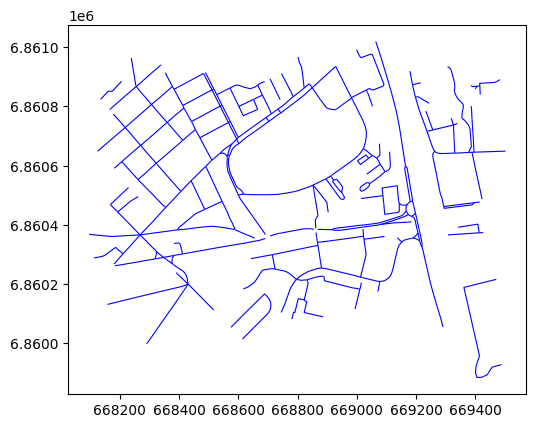

In [15]:
generalized_de = c4.eliminate_dead_ends(dead_ends, length = 500, keep_longest = True)

generalized_de.plot(column = 'deadend', cmap = de_col, linewidth = 0.8) #Display result gdf with color according to section status (i.e dead end = True or False)

**2.2.3/** 🟡🟠🔴 Display intermediary results 

In [16]:
# 🟡🟠🔴 Display intermediary results    

symbology_on_off = ipywidgets.Checkbox(value=True, description='symbology_on')

def bf_af_1(scale='1:7500', symbology_on= True):
    global SCREEN
    fig = plt.figure(figsize=SCREEN[scale])
    ax1 = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)	
    plt.title("Before")	
    scalebar = AnchoredSizeBar(ax1.transData,
                                        250,  
                                        '250 m',  
                                        'lower left',  
                                        pad=0.5,
                                        color='black',
                                        frameon=True,
                                        size_vertical=1)
    ax1.add_artist(scalebar)
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    
    fig2 = plt.figure(figsize=SCREEN[scale])
    ax2 = fig2.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)
    plt.title("After")	
    scalebar = AnchoredSizeBar(ax2.transData,
                                        250,  
                                        '250 m',  
                                        'lower left',  
                                        pad=0.5,
                                        color='black',
                                        frameon=True,
                                        size_vertical=1)
    ax2.add_artist(scalebar)	
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)	
    
    if scale == '1:25000':
        plt.subplots_adjust(hspace=0)
        
    if symbology_on == True:
        pbar = tqdm(range(34), total = 34, desc = "displaying datas : ")
        
        for i in reversed(range(2,7)):
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == f"{i}")].plot(ax=ax1, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)
            pbar.update(1.0)
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == f"{i}")].plot(ax=ax1, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])
            pbar.update(1.0)

            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax2, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)
            pbar.update(1.0)
            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax2, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])
            pbar.update(1.0)
        for i in range(1):
            gdf_bckgrnd.plot(ax=ax2, color = SYMBO_PARAM['bckgrnd_col'])
            pbar.update(1.0)
            gdf_bckgrnd.plot(ax=ax1, color = SYMBO_PARAM['bckgrnd_col'])
            pbar.update(1.0)

            selected_data['gdf_trainline'].plot(ax=ax1, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])
            pbar.update(1.0)
            selected_data['gdf_trainline'].plot(ax=ax2, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])
            pbar.update(1.0) 

            selected_data['gdf_commune'].plot(ax=ax1, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle='dashed')
            pbar.update(1.0)
            selected_data['gdf_commune'].plot(ax=ax2, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle='dashed')
            pbar.update(1.0) 
            
            col_buildings = matcol.LinearSegmentedColormap.from_list('colbuildings',
                                                            [SYMBO_PARAM['agricultural_col'], SYMBO_PARAM['annex_col'],SYMBO_PARAM['com_serv_col'], SYMBO_PARAM['other_col'],SYMBO_PARAM['religious_col'],SYMBO_PARAM['residential_col'],SYMBO_PARAM['sports_field_col']])    
            selected_data['gdf_building'].plot(ax=ax1, column = 'usage_1', cmap = col_buildings)
            pbar.update(1.0)
            selected_data['gdf_building'].plot(ax=ax2, column = 'usage_1', cmap = col_buildings)
            pbar.update(1.0)

            selected_data['gdf_sportfield'].plot(ax=ax1, color = SYMBO_PARAM['sports_field_col'])
            pbar.update(1.0)
            selected_data['gdf_sportfield'].plot(ax=ax2, color = SYMBO_PARAM['sports_field_col'])
            pbar.update(1.0)

            selected_data['gdf_vegetation'].plot(ax=ax1, color = SYMBO_PARAM['vegetation_col'])
            pbar.update(1.0)
            selected_data['gdf_vegetation'].plot(ax=ax2, color = SYMBO_PARAM['vegetation_col'])
            pbar.update(1.0)

            selected_data['gdf_water'].plot(ax=ax1, color = SYMBO_PARAM['water_col'])
            pbar.update(1.0)
            selected_data['gdf_water'].plot(ax=ax2, color = SYMBO_PARAM['water_col'])
            pbar.update(1.0)
        pbar.close()     
    else:
        pbar = tqdm(range(2), total = 2, desc = "displaying datas : ")
        for i in range(1):
            selected_data['gdf_road'].plot(ax =ax1, linewidth = 0.8)
            pbar.update(1.0)
            list_generalized[len(list_generalized)-1].plot(ax =ax2, linewidth = 0.8)
            pbar.update(1.0)
        pbar.close()
       
ipywidgets.interact(bf_af_1, scale = ['1:25000','1:10000', '1:7500', '1:5000'], symbology_on = True)

interactive(children=(Dropdown(description='scale', index=2, options=('1:25000', '1:10000', '1:7500', '1:5000'…

<function __main__.bf_af_1(scale='1:7500', symbology_on=True)>

**2.2.4/** 🟡🟠🔴 Selecting the roundabouts to collapse using "detect_roundabouts" algorithm

In [17]:
# 🟡🟠🔴 Step 3 : Selecting the roundabouts to collapse using "detect_roundabouts"
count = -1
area_threshold = ipywidgets.IntSlider(value=500, min=0, max=2500, step=10, continuous_update=False, style= {'description_width': 'initial'})
miller_index = ipywidgets.FloatSlider(value =0.95, min = 0,max = 1,step = 0.01,continuous_update=False)
revert1 = ipywidgets.Button(description='revert',icon='undo')

def plt_rb(area_threshold, miller_index, scale):
    for i in tqdm(range(1)):
        global list_generalized
        global rb
        global SCREEN
        global count
        global rb

        try:
            rb = c4.detect_roundabouts(list_generalized[count], area_threshold = area_threshold, miller_index = miller_index)
        except IndexError:
            count += 1
            rb = c4.detect_roundabouts(list_generalized[count], area_threshold = area_threshold, miller_index = miller_index)
            
        fig = plt.figure(figsize=SCREEN[scale])
        ax = fig.add_subplot(111)
        plt.xlim(668198, 669411)
        plt.ylim(6860147, 6860869)		
        scalebar = AnchoredSizeBar(ax.transData,
                                                250,  
                                                '250 m',  
                                                'lower left',  
                                                pad=0.5,
                                                color='black',
                                                frameon=True,
                                                size_vertical=1)
        ax.add_artist(scalebar)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
            
        # Display the result
        list_generalized[count].plot(ax =ax, linewidth = 0.8)
        if type(rb) == gp.geodataframe.GeoDataFrame:
            rb.plot(ax = ax, color = "orange") 
        
def revert_fun(b):
    global count 
    global out_dtc_rb
    count -= 1
    clear_output()
    out_dtc_rb = ipywidgets.interactive(plt_rb, area_threshold = area_threshold, miller_index = miller_index, scale = scale)
    display(out_dtc_rb, revert1)
revert1.on_click(revert_fun)


out_dtc_rb = ipywidgets.interactive(plt_rb, area_threshold = area_threshold, miller_index = miller_index, scale = scale)
display(out_dtc_rb, revert1)

interactive(children=(IntSlider(value=500, continuous_update=False, description='area_threshold', max=2500, st…

Button(description='revert', icon='undo', style=ButtonStyle())

💬 **Miller index** give an idea of how **round** should be the feature to detect. The more it is close to **1**, the **rounder** detected features have to be.

**2.2.4'/** Detect roundabouts algorithm details

no roundabouts detected


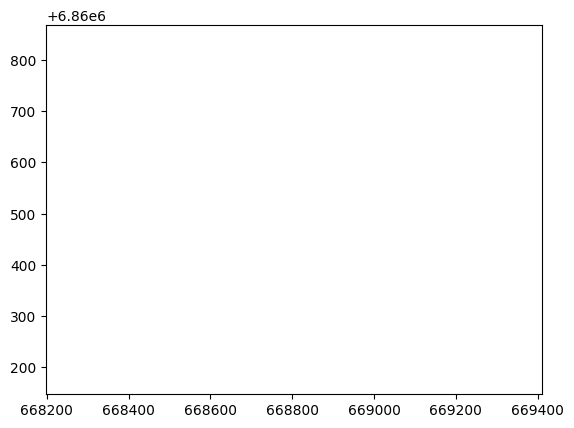

In [20]:
roundabts = c4.detect_roundabouts(list_generalized[count], area_threshold = 15, miller_index = 0.85) 

#Configuring display window
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlim(668198, 669411)
plt.ylim(6860147, 6860869)

if roundabts: 
    roundabts.plot(ax=ax, color = 'orange')
    list_generalized[count].plot(ax =ax, linewidth = 0.8)
else: 
    print("no roundabouts detected")

**2.2.5/** 🟡🟠🔴 Selecting the branching crossroads to collapse using "detect_branching_crossroads"

In [21]:
# 🟡🟠🔴 Step 4 : Selecting the branching crossroads to collapse using "detect_branching_crossroads"
count = -1
revert2 = ipywidgets.Button(description='revert',icon='undo')
area_threshold_bc = ipywidgets.IntSlider(value =4000, min = 0,max = 10000,step = 100,continuous_update=False,style= {'description_width': 'initial'})
maximum_distance_area = ipywidgets.FloatSlider(value =0.5, min = 0,max = 1,step = 0.025,continuous_update=False, style= {'description_width': 'initial'})
allow_middle_node = ipywidgets.Checkbox(value=True, description="allow_middle_node ") 
middle_angle_tolerance = ipywidgets.FloatSlider(value =10, min = 0,max = 40,step = 1,continuous_update=False, style = {'description_width': 'initial'}) 
allow_single_4degree_node = ipywidgets.Checkbox(value=True, description="allow_single_4degree_node")

def plt_bc(area_threshold_bc, maximum_distance_area, allow_middle_node, middle_angle_tolerance, allow_single_4degree_node, scale = '1:7500'):
    for i in tqdm(range(1)):
        global bc 
        global list_generalized
        global SCREEN
        global roundabouts
        global count

        if 'rb' not in globals():
            print("it is recommanded to perform roundabouts detection prior to branching crossroads detection")
            try:
                bc = c4.detect_branching_crossroads(list_generalized[count], area_threshold = area_threshold_bc, maximum_distance_area = maximum_distance_area,
                                                    allow_middle_node = allow_middle_node, middle_angle_tolerance = middle_angle_tolerance, allow_single_4degree_node = allow_single_4degree_node)
            except IndexError:
                count += 1
                bc = c4.detect_branching_crossroads(list_generalized[count], area_threshold = area_threshold_bc, maximum_distance_area = maximum_distance_area,
                                                    allow_middle_node = allow_middle_node, middle_angle_tolerance = middle_angle_tolerance, allow_single_4degree_node = allow_single_4degree_node)
        else: 
            try:                                           
                bc = c4.detect_branching_crossroads(list_generalized[count], roundabouts = rb, area_threshold = area_threshold_bc, maximum_distance_area = maximum_distance_area,
                                                    allow_middle_node = allow_middle_node, middle_angle_tolerance = middle_angle_tolerance, allow_single_4degree_node = allow_single_4degree_node)
            except IndexError:
                count += 1
                bc = c4.detect_branching_crossroads(list_generalized[count],roundabouts = rb, area_threshold = area_threshold_bc, maximum_distance_area = maximum_distance_area,
                                                    allow_middle_node = allow_middle_node, middle_angle_tolerance = middle_angle_tolerance, allow_single_4degree_node = allow_single_4degree_node)
        # Setting up the map
        fig = plt.figure(figsize=SCREEN[scale])
        ax = fig.add_subplot(111)
        plt.xlim(668198, 669411)
        plt.ylim(6860147, 6860869)		
        scalebar = AnchoredSizeBar(ax.transData,
                                                        250,  
                                                        '250 m',  
                                                        'lower left',  
                                                        pad=0.5,
                                                        color='black',
                                                        frameon=True,
                                                        size_vertical=1)
        ax.add_artist(scalebar)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

        # Display the result
        list_generalized[count].plot(ax =ax, linewidth = 0.8)
        if type(bc) == gp.geodataframe.GeoDataFrame:
            bc.plot(ax = ax, color = "orange") 
            
def revert_fun(b):
    global count 
    global out_dtc_bc
    count -= 1
    clear_output()
    out_dtc_bc = ipywidgets.interact(plt_bc, area_threshold_bc = area_threshold_bc, maximum_distance_area = maximum_distance_area, allow_middle_node = allow_middle_node, 
                                             middle_angle_tolerance = middle_angle_tolerance, allow_single_4degree_node = allow_single_4degree_node, scale = scale)
    display(out_dtc_bc, revert2)
revert2.on_click(revert_fun)

out_dtc_bc = ipywidgets.interactive(plt_bc, area_threshold_bc = area_threshold_bc, maximum_distance_area = maximum_distance_area, allow_middle_node = allow_middle_node, 
                                             middle_angle_tolerance = middle_angle_tolerance, allow_single_4degree_node = allow_single_4degree_node, scale = scale)
display(out_dtc_bc, revert2)

interactive(children=(IntSlider(value=4000, continuous_update=False, description='area_threshold_bc', max=1000…

Button(description='revert', icon='undo', style=ButtonStyle())

💬 Branching crossroads should be detected **after** roundabouts, as providing roundabouts in branching crossroads detection gives **better** results when collapsing those objects.

**2.2.5'/** Detect branching crossroads algorithm details

No branching crossroads detected


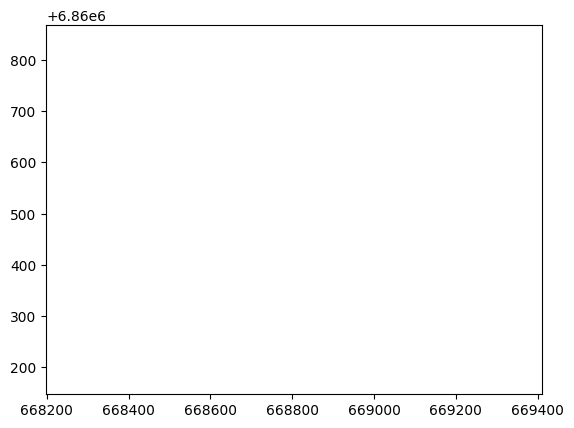

In [24]:
branching = c4.detect_branching_crossroads(list_generalized[count], roundabouts = rb, area_threshold = 1, maximum_distance_area = 0.5,
                                                    allow_middle_node = True, middle_angle_tolerance = 10, allow_single_4degree_node = True)
#Configuring display window
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlim(668198, 669411)
plt.ylim(6860147, 6860869)

if branching:
    branching.plot(ax=ax, color = 'orange')
    list_generalized[count].plot(ax =ax, linewidth = 0.8)
else:
    print("No branching crossroads detected")

**2.2.6/** 🟡🟠🔴 Using collapse branching crossroads algorithm 

In [25]:
# 🟡🟠🔴 Step 5 : Collapsing branching crossroads
revert3 = ipywidgets.Button(description='revert',icon='undo')
count = -1
count_intrn = 0
maximum_area = ipywidgets.IntSlider(value =1000, min = 0,max = 500000,step = 10,continuous_update=False,style= {'description_width': 'initial'})

def elim_bc(maximum_area, scale = '1:7500'):
    for i in tqdm(range(1)):
        global list_generalized
        global count_intrn
        global bc 
        global SCREEN
        global dead_ends
        global count
            
        if 'bc' not in globals():
            print("you must perform branching crossroads detection before collapsing them !")
        else: 
            count_intrn += 1
            if count_intrn > 1:
                del(list_generalized[-1])
            try:    
                generalized = c4.collapse_branching_crossroads(list_generalized[count], bc, maximum_area = maximum_area)
            except IndexError: 
                count +=1
                generalized = c4.collapse_branching_crossroads(list_generalized[count], bc, maximum_area = maximum_area)
                
            list_generalized.append(generalized)
            
            # Setting up the map
            fig = plt.figure(figsize=SCREEN[scale])
            ax = fig.add_subplot(111)
            plt.xlim(668198, 669411)
            plt.ylim(6860147, 6860869)		
            scalebar = AnchoredSizeBar(ax.transData,
                                                            250,  
                                                            '250 m',  
                                                            'lower left',  
                                                            pad=0.5,
                                                            color='black',
                                                            frameon=True,
                                                            size_vertical=1)
            ax.add_artist(scalebar)
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)

            # Display the result
            bc.plot(ax=ax, color = "red",alpha = 0.25)
            generalized.plot(ax =ax, linewidth = 0.8)

def revert_fun(b):
    global count 
    global out_elim_bc
    count -= 1
    clear_output()
    out_elim_bc = ipywidgets.interactive(elim_bc, maximum_area = maximum_area, scale = scale)
    display(out_elim_bc, revert3)
revert3.on_click(revert_fun)
                
out_elim_bc = ipywidgets.interactive(elim_bc, maximum_area = maximum_area, scale = scale)
display(out_elim_bc, revert3)

interactive(children=(IntSlider(value=1000, continuous_update=False, description='maximum_area', max=500000, s…

Button(description='revert', icon='undo', style=ButtonStyle())

💬 Once again, you can decide to **keep** some of the branching crossroads if you think they are important in your map, by configuring the **area threshold**.

**2.2.6'/** Collapse branching crossroads algorithm

In [29]:
generalized_roads = c4.collapse_branching_crossroads(list_generalized[count], crossroads = bc, maximum_area = 1000)

#Configuring display window
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlim(668198, 669411)
plt.ylim(6860147, 6860869)

bc.plot(ax=ax, color = 'orange')
generalized_roads.plot(ax =ax, linewidth = 0.8)
  

AttributeError: 'NoneType' object has no attribute 'to_dict'

**2.2.7/** 🟡🟠🔴 Using collapse roundabouts algorithm

In [30]:
# 🟡🟠🔴 Step 6 : Collapsing roundabouts
revert4 = ipywidgets.Button(description='revert',icon='undo')
maximum_diameter = ipywidgets.IntSlider(value =50, min = 0,max = 500,step = 5, continuous_update=False, style= {'description_width': 'initial'})
count_intrn = 0
count = -1 
def plt_cllpse_rb(maximum_diameter, scale = '1:7500'):
    global SCREEN
    global roudabouts
    global list_generalized
    global count
    global count_intrn 

    for i in tqdm(range(1)):
        if 'rb' not in globals():
            print("you must perform roundabouts detection before collapsing them !")
        else: 
            count_intrn += 1
            if count_intrn > 1:
                del(list_generalized[-1])
            try:
                generalized = c4.collapse_roundabouts(list_generalized[count], rb, maximum_diameter = maximum_diameter)
            except IndexError:
                count += 1
                generalized = c4.collapse_roundabouts(list_generalized[count], rb, maximum_diameter = maximum_diameter)
                
            list_generalized.append(generalized)

            # Setting up the map
            fig = plt.figure(figsize=SCREEN[scale])
            ax = fig.add_subplot(111)
            plt.xlim(668198, 669411)
            plt.ylim(6860147, 6860869)		
            scalebar = AnchoredSizeBar(ax.transData,
                                                            250,  
                                                            '250 m',  
                                                            'lower left',  
                                                            pad=0.5,
                                                            color='black',
                                                            frameon=True,
                                                            size_vertical=1)
            ax.add_artist(scalebar)
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)

            # Display the result
            rb.plot(ax =ax, color= "red", alpha = 0.25)
            generalized.plot(ax = ax, linewidth = 0.8) 

def revert_fun(b):
    global count 
    global out_cllpse_rb
    count -= 1
    clear_output()
    out_cllpse_rb = ipywidgets.interactive(plt_cllpse_rb, maximum_diameter = maximum_diameter, scale = scale)
    display(out_cllpse_rb, revert4)
revert4.on_click(revert_fun)

out_cllpse_rb = ipywidgets.interactive(plt_cllpse_rb, maximum_diameter = maximum_diameter, scale = scale)
display(out_cllpse_rb, revert4)

interactive(children=(IntSlider(value=50, continuous_update=False, description='maximum_diameter', max=500, st…

Button(description='revert', icon='undo', style=ButtonStyle())

💬 Eventhough roundabouts can act as **landmarks** and be useful to display in a map at large scale, removing them **simplifies** the shape of the road network and make the use of some other road network algorithms easier.

**2.2.7'/** Collapse roundabouts algorithm details

In [31]:
generalized_roads = c4.collapse_roundabouts(list_generalized[count], roundabouts = rb, maximum_diameter = 50)

#Configuring display window
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlim(668198, 669411)
plt.ylim(6860147, 6860869)

rb.plot(ax=ax, color = 'orange')
generalized_roads.plot(ax =ax, linewidth = 0.8)

AttributeError: 'NoneType' object has no attribute 'to_dict'

**2.2.8/** 🟡🟠🔴 Using detect dual carriageways algorithm

In [32]:
# 🟡🟠🔴 Step 7 : Selecting the dual carriageways to collapse using "detect_dual_carriageways"
count = -1
revert5 = ipywidgets.Button(description='revert',icon='undo')
concavity = ipywidgets.FloatSlider(value =0.85, min = 0,max = 1,step = 0.05,continuous_update=False)
elongation = ipywidgets.IntSlider(value =6.0, min = 0,max = 10,step = 1,continuous_update=False)
compactness = ipywidgets.FloatSlider(value =0.12, min = 0,max = 1,step = 0.05,continuous_update=False)
area = ipywidgets.IntSlider(value = 60000, min = 0,max = 100000,step = 1000,continuous_update=False)
width = ipywidgets.IntSlider(value = 20.0, min = 0,max = 40,step = 5,continuous_update=False)
huber = ipywidgets.IntSlider(value = 16, min = 0,max = 32,step = 4,continuous_update=False)

def plt_dtc_dc(concavity, elongation, compactness, area, width, huber, scale):
    global SCREEN
    global dc
    global list_generalized
    global count
    
    for i in tqdm(range(1)):
        try:
            dc = c4.detect_dual_carriageways(list_generalized[count], concavity = concavity, elongation = elongation, compactness = compactness, area = area, width = width, huber = huber)
        except IndexError:
            count += 1
            dc = c4.detect_dual_carriageways(list_generalized[count], concavity = concavity, elongation = elongation, compactness = compactness, area = area, width = width, huber = huber)

        # Setting up the map
        fig = plt.figure(figsize=SCREEN[scale])
        ax = fig.add_subplot(111)
        plt.xlim(668198, 669411)
        plt.ylim(6860147, 6860869)		
        scalebar = AnchoredSizeBar(ax.transData,
                                                        250,  
                                                        '250 m',  
                                                        'lower left',  
                                                        pad=0.5,
                                                        color='black',
                                                        frameon=True,
                                                        size_vertical=1)
        ax.add_artist(scalebar)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

        list_generalized[count].plot(ax= ax, color = "grey",linewidth = 0.8)
        if type(dc) == gp.geodataframe.GeoDataFrame:
            dc.plot(ax=ax, color = "red")

def revert_fun(b):
    global count 
    global out_dtc_dc
    count -= 1
    clear_output()
    out_dtc_dc = ipywidgets.interactive(plt_dtc_dc, concavity = concavity, elongation = elongation, compactness = compactness, area = area, width = width, huber = huber, scale = scale)
    display(out_dtc_dc, revert5)
revert5.on_click(revert_fun)  

out_dtc_dc = ipywidgets.interactive(plt_dtc_dc, concavity = concavity, elongation = elongation, compactness = compactness, area = area, width = width, huber = huber, scale = scale)
display(out_dtc_dc, revert5)

interactive(children=(FloatSlider(value=0.85, continuous_update=False, description='concavity', max=1.0, step=…

Button(description='revert', icon='undo', style=ButtonStyle())

💬 Sometimes, the two roads detected as dual carriageways are not of the **same nature in reality** (i.e not twice the same road with different directions but two different roads the are next to eachother), which makes the settings of this algorithm **sensitive**. 

**2.2.8'/** Detect dual carriageways algorithm details

<Axes: >

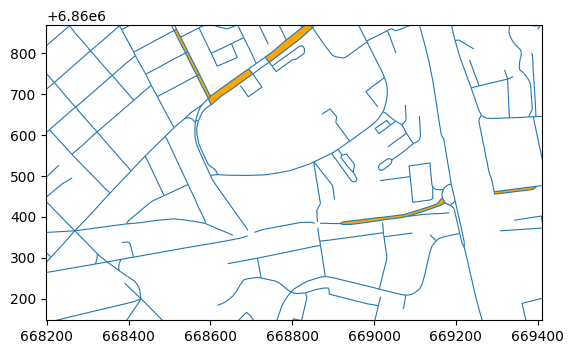

In [33]:
dual_c = c4.detect_dual_carriageways(list_generalized[count], concavity = 0.85, elongation = 6.0, compactness = 0.12, area = 60000, width = 20.0, huber = 16)

#Configuring display window
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlim(668198, 669411)
plt.ylim(6860147, 6860869)

dual_c.plot(ax=ax, color = 'orange')
list_generalized[count].plot(ax =ax, linewidth = 0.8)

**2.2.9/** 🟡🟠🔴 Using collapse dual carriageways algorithm

In [34]:
# 🟡🟠🔴 Step 8 : Collapsing dual carriageways
count_intrn = 0
count = -1
revert6 = ipywidgets.Button(description='revert',icon='undo')
sigma = ipywidgets.IntSlider(value = 3, min = 1,max = 10,step = 1,continuous_update=False)

def elim_dc(sigma, scale='1:7500'):
    global list_generalized
    global count
    global dc
    global count_intrn
    
    if 'dc' not in globals():
        print("you must detect dual carriageways before collapsing them !")
    else:
        count_intrn += 1
        if count_intrn > 1:
            del(list_generalized[-1])
        try:
            generalized = c4.collapse_dual_carriageways(list_generalized[count], dc, sigma = sigma, propagate_attributes = ['cleabs','nature','importance'])
        except IndexError:
            count += 1
            generalized = c4.collapse_dual_carriageways(list_generalized[count], dc, sigma = sigma, propagate_attributes = ['cleabs','nature','importance'])
        list_generalized.append(generalized)

        # Setting up the map
        fig = plt.figure(figsize=SCREEN[scale])
        ax = fig.add_subplot(111)
        plt.xlim(668198, 669411)
        plt.ylim(6860147, 6860869)		
        scalebar = AnchoredSizeBar(ax.transData,
                                                250,  
                                                '250 m',  
                                                'lower left',  
                                                pad=0.5,
                                                color='black',
                                                frameon=True,
                                                size_vertical=1)
        ax.add_artist(scalebar)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)

        if type(dc) == gp.geodataframe.GeoDataFrame:
                dc.plot(ax=ax, color = "red",alpha = 0.25)
        generalized.plot(ax=ax, linewidth = 0.8)

def revert_fun(b):
    global count 
    global out_elim_dc
    count -= 1
    clear_output()
    out_elim_dc = ipywidgets.interactive(elim_dc, sigma = sigma, scale = scale)
    display(out_elim_dc, revert6)
revert6.on_click(revert_fun)

out_elim_dc = ipywidgets.interactive(elim_dc, sigma = sigma, scale = scale)
display(out_elim_dc, revert6)

interactive(children=(IntSlider(value=3, continuous_update=False, description='sigma', max=10, min=1), Dropdow…

Button(description='revert', icon='undo', style=ButtonStyle())

**2.2.9'/** Collapse dual carriageways algorithm details

<Axes: >

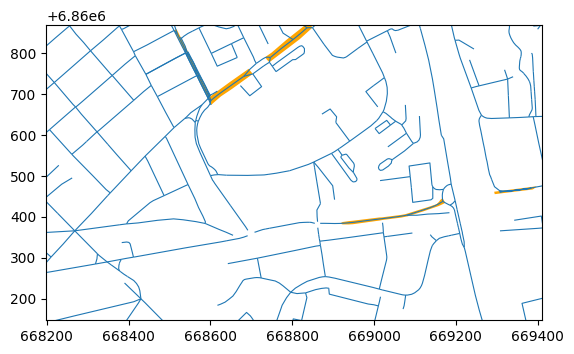

In [37]:
generalized_roads = c4.collapse_dual_carriageways(list_generalized[-2], carriageways = dc, sigma = 3, propagate_attributes = ['cleabs','nature','importance'])

#Configuring display window
fig = plt.figure()
ax = fig.add_subplot(111)
plt.xlim(668198, 669411)
plt.ylim(6860147, 6860869)

dual_c.plot(ax=ax, color = 'orange')
generalized_roads.plot(ax =ax, linewidth = 0.8)

**2.2.10/** 🟡🟠🔴 Display intermediary results 

In [38]:
# 🟡🟠🔴 Display intermediary results    

symbology_on_off = ipywidgets.Checkbox(value=True, description='symbology_on')

def bf_af_2(scale='1:7500', symbology_on= True):
    global SCREEN
    global SYMBO_PARAM
    fig = plt.figure(figsize=SCREEN[scale])
    ax1 = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)	
    plt.title("Before")	
    scalebar = AnchoredSizeBar(ax1.transData,
                                        250,  
                                        '250 m',  
                                        'lower left',  
                                        pad=0.5,
                                        color='black',
                                        frameon=True,
                                        size_vertical=1)
    ax1.add_artist(scalebar)
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    
    fig2 = plt.figure(figsize=SCREEN[scale])
    ax2 = fig2.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)
    plt.title("After")	
    scalebar = AnchoredSizeBar(ax2.transData,
                                        250,  
                                        '250 m',  
                                        'lower left',  
                                        pad=0.5,
                                        color='black',
                                        frameon=True,
                                        size_vertical=1)
    ax2.add_artist(scalebar)	
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)	
        
    if symbology_on == True:
        pbar = tqdm(range(34), total = 34, desc = "displaying datas : ")
        
        for i in reversed(range(2,7)):
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == f"{i}")].plot(ax=ax1, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)
            pbar.update(1.0)
            selected_data['gdf_road'][(selected_data['gdf_road'].importance == f"{i}")].plot(ax=ax1, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])
            pbar.update(1.0)

            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax2, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)
            pbar.update(1.0)
            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax2, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])
            pbar.update(1.0)
        for i in range(1):
            gdf_bckgrnd.plot(ax=ax2, color = SYMBO_PARAM['bckgrnd_col'])
            pbar.update(1.0)
            gdf_bckgrnd.plot(ax=ax1, color = SYMBO_PARAM['bckgrnd_col'])
            pbar.update(1.0)

            selected_data['gdf_trainline'].plot(ax=ax1, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])
            pbar.update(1.0)
            selected_data['gdf_trainline'].plot(ax=ax2, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])
            pbar.update(1.0) 

            selected_data['gdf_commune'].plot(ax=ax1, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle='dashed')
            pbar.update(1.0)
            selected_data['gdf_commune'].plot(ax=ax2, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle='dashed')
            pbar.update(1.0) 
            
            col_buildings = matcol.LinearSegmentedColormap.from_list('colbuildings',
                                                            [SYMBO_PARAM['agricultural_col'], SYMBO_PARAM['annex_col'],SYMBO_PARAM['com_serv_col'], SYMBO_PARAM['other_col'],SYMBO_PARAM['religious_col'],SYMBO_PARAM['residential_col'],SYMBO_PARAM['sports_field_col']])    
            selected_data['gdf_building'].plot(ax=ax1, column = 'usage_1', cmap = col_buildings)
            pbar.update(1.0)
            selected_data['gdf_building'].plot(ax=ax2, column = 'usage_1', cmap = col_buildings)
            pbar.update(1.0)

            selected_data['gdf_sportfield'].plot(ax=ax1, color = SYMBO_PARAM['sports_field_col'])
            pbar.update(1.0)
            selected_data['gdf_sportfield'].plot(ax=ax2, color = SYMBO_PARAM['sports_field_col'])
            pbar.update(1.0)

            selected_data['gdf_vegetation'].plot(ax=ax1, color = SYMBO_PARAM['vegetation_col'])
            pbar.update(1.0)
            selected_data['gdf_vegetation'].plot(ax=ax2, color = SYMBO_PARAM['vegetation_col'])
            pbar.update(1.0)

            selected_data['gdf_water'].plot(ax=ax1, color = SYMBO_PARAM['water_col'])
            pbar.update(1.0)
            selected_data['gdf_water'].plot(ax=ax2, color = SYMBO_PARAM['water_col'])
            pbar.update(1.0)
        pbar.close()     
    else:
        pbar = tqdm(range(2), total = 2, desc = "displaying datas : ")
        for i in range(1):
            selected_data['gdf_road'].plot(ax =ax1, linewidth = 0.8)
            pbar.update(1.0)
            list_generalized[len(list_generalized)-1].plot(ax =ax2, linewidth = 0.8)
            pbar.update(1.0)
        pbar.close()
ipywidgets.interact(bf_af_2, scale = ['1:25000','1:10000', '1:7500', '1:5000'], symbology_on = True)

interactive(children=(Dropdown(description='scale', index=2, options=('1:25000', '1:10000', '1:7500', '1:5000'…

<function __main__.bf_af_2(scale='1:7500', symbology_on=True)>

**2.2.11/** 🟡🟠🔴 Removing road sections depending on network density (🏗 work in progess...)

In [ ]:
# 🟡🟠🔴 Removing road sections depending on network density (🏗 work in progess...) 

### **2.3/** Building generalisation

Let's continue by generalizing **buildings**. On the contrary of roads where differences between targeted rendered depends on **settings** within the different algorithms, the choice of the **algorithms** themselves is important when it comes to building generalization.

In [ ]:
# 🟡🟠🔴  Preparing the dictionnary containing building data
build = {'base_building':selected_data['gdf_building'].copy()}
build['base_building'] = build['base_building'].reset_index(drop = True)

# Calculating area of each builing (used later)
for i in range(len(build['base_building'])):
    build['base_building'].loc[i,'area'] = build['base_building'].loc[i,'geometry'].area
build['base_building'].head(2)

In [ ]:
# 🔴 Partition the building according to the network structure
partition = c4.partition_networks(build['base_building'], selected_data['gdf_road'])

partition_gdf = gp.GeoDataFrame(geometry=partition[-1])

# Setting up the map
fig = plt.figure(figsize=(SCREEN['1:7500']))
ax = fig.add_subplot(111)
plt.xlim(668198, 669411)
plt.ylim(6860147, 6860869)	
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)	

partition_gdf.plot(ax=ax, alpha = 0.2, edgecolor = 'black')
for i in range(len(partition[0])):
    gdf = build['base_building'].copy()
    gdf = gdf.iloc[partition[0][i]]
    gdf.plot(ax=ax,color = (np.random.uniform(0, 1),np.random.uniform(0, 1),np.random.uniform(0, 1)))

💬 Partitioning is an **important** step when generalizing **big** dataset, since it accelerate processings.

In [ ]:
# 🔴 Transforming buildings into built up area with the 'morphological_amalgamation' algorithm

def ma(buffer, edge_length, symbology_on, scale = '1:7500'):
    
    # Setting up the map
    fig = plt.figure(figsize=(SCREEN[scale]))
    ax = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)		

    if symbology_on == True:
        pbar = tqdm(range(76), total = 76, desc = "displaying datas : ")    
        for i in range(1):
            gdf_bckgrnd.plot(ax=ax, color = SYMBO_PARAM['bckgrnd_col'])
            pbar.update(1.0)
    
            selected_data['gdf_trainline'].plot(ax=ax, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])
            pbar.update(1.0) 

            selected_data['gdf_commune'].plot(ax=ax, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle='dashed')
            pbar.update(1.0) 
            
            selected_data['gdf_sportfield'].plot(ax=ax, color = SYMBO_PARAM['sports_field_col'])
            pbar.update(1.0)

            selected_data['gdf_vegetation'].plot(ax=ax, color = SYMBO_PARAM['vegetation_col'])
            pbar.update(1.0)
        
            selected_data['gdf_water'].plot(ax=ax, color = SYMBO_PARAM['water_col'])
            pbar.update(1.0)
    
        for i in range(len(partition[0])):
            gdf = build['base_building'].copy()
            gdf = gdf.iloc[partition[0][i]]

            try:
                generalized = c4.morphological_amalgamation(list(gdf.geometry), buffer = buffer, edge_length = edge_length) 
                
            except: 
                generalized = gdf.geometry
            
            generalized_gdf = gp.GeoDataFrame(geometry=gp.GeoSeries(generalized))
            generalized_gdf = generalized_gdf.reset_index(drop = True)
            build[f'boffet_{i}'] = generalized_gdf
            build[f'boffet_{i}'].plot(ax=ax, color = SYMBO_PARAM['residential_col'])
            pbar.update(1.0)

        for i in reversed(range(2,7)):
            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)
            pbar.update(1.0)
            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])
            pbar.update(1.0)

        pbar.close()

    else:
        pbar = tqdm(range(60), total = 60, desc = "displaying generalized buildings : ")
        for i in range(len(partition[0])):
            gdf = build['base_building'].copy()
            gdf = gdf.iloc[partition[0][i]]

            try:
                generalized = c4.morphological_amalgamation(list(gdf.geometry), buffer = buffer, edge_length = edge_length) 
            except: 
                generalized = gdf.geometry
                
            generalized_gdf = gp.GeoDataFrame(geometry=gp.GeoSeries(generalized))
            generalized_gdf = generalized_gdf.reset_index(drop = True)
            build[f'ma_{i}'] = generalized_gdf
            build[f'ma_{i}'].plot(ax=ax)
            pbar.update(1.0)
        pbar.close()

ipywidgets.interact(ma, scale = ['1:25000','1:10000', '1:7500', '1:5000'], symbology_on = False, 
                        buffer = ipywidgets.IntSlider(value = 10, min = 0,max = 100,step = 1,continuous_update=False), 
                        edge_length = ipywidgets.IntSlider(value = 0, min = 0,max = 50,step = 1,continuous_update=False))

💬 Another way of transforming buildings into **built up area** is to use the **'boffet_area'** algorithm

In [ ]:
# 🔴 Transforming buildings into built up area with the 'boffet_area' algorithm

def boff_area(buffer, erosion, symbology_on, simplification_dist, scale = '1:7500'):

    # Setting up the map
    fig = plt.figure(figsize=SCREEN[scale])
    ax = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)		
    scalebar = AnchoredSizeBar(ax.transData,
                                    250,  
                                    '250 m',  
                                    'lower left',  
                                    pad=0.5,
                                    color='black',
                                    frameon=True,
                                    size_vertical=1)
    ax.add_artist(scalebar)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    if symbology_on == True:
        pbar = tqdm(range(len(partition[0])+17), total = len(partition[0])+17, desc = "displaying datas : ")
        for i in range(1):
            gdf_bckgrnd.plot(ax=ax, color = SYMBO_PARAM['bckgrnd_col'])
            pbar.update(1.0)
            for i in range(len(partition[0])):
                gdf = build['base_building'].copy()
                gdf = gdf.iloc[partition[0][i]]
                try:
                    generalized = c4.boffet_areas(gdf.geometry, buffer = buffer,  erosion = erosion, simplification_distance = simplification_dist)
                except: 
                    generalized = gdf.geometry  
                generalized_gdf = gp.GeoDataFrame(geometry=gp.GeoSeries(generalized))
                generalized_gdf.plot(ax=ax, color = SYMBO_PARAM['residential_col'])
                build[f'boffet_{i}'] = generalized_gdf
                pbar.update(1.0)
            selected_data['gdf_trainline'].plot(ax=ax, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])
            pbar.update(1.0) 
            selected_data['gdf_commune'].plot(ax=ax, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle='dashed')
            pbar.update(1.0) 
            selected_data['gdf_sportfield'].plot(ax=ax, color = SYMBO_PARAM['sports_field_col'])
            pbar.update(1.0)
            selected_data['gdf_vegetation'].plot(ax=ax, color = SYMBO_PARAM['vegetation_col'])
            pbar.update(1.0)
            selected_data['gdf_water'].plot(ax=ax, color = SYMBO_PARAM['water_col'])
            pbar.update(1.0)
        for i in reversed(range(2,7)):
            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)
            pbar.update(1.0)
            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])
            pbar.update(1.0)
        pbar.close()     
    else:    
        pbar = tqdm(range(len(partition[0])), total = len(partition[0]), desc = "displaying generalized buildings: ")
        for i in range(len(partition[0])):
            gdf = build['base_building'].copy()
            gdf = gdf.iloc[partition[0][i]]
            try:
                generalized = c4.boffet_areas(gdf.geometry, buffer = buffer,  erosion = erosion, simplification_distance = simplification_dist)
            except: 
                generalized = gdf.geometry  
            generalized_gdf = gp.GeoDataFrame(geometry=gp.GeoSeries(generalized))
            generalized_gdf.plot(ax=ax)
            build[f'boffet_{i}'] = generalized_gdf
            pbar.update(1.0)
        pbar.close() 

ipywidgets.interact(boff_area, buffer = ipywidgets.IntSlider(value = 8, min=0, max=100, step=1,  continuous_update=False),
                               erosion = ipywidgets.FloatSlider(min=0.1, max=100, step=1, continuous_update=False), 
                               simplification_dist = ipywidgets.IntSlider(min=1, max=100, step=1, continuous_update=False,style= {'description_width': 'initial'}),
                               scale = ['1:25000','1:10000', '1:7500', '1:5000'],
                               symbology_on = False) 

💬 In this case we use the **boffet_area** algorithm directly to generalize our buildings. Note that this algorithm was firstly design to **separate** rural and urban area **prior** to other generalisation processes. 

In [ ]:
# adding close polygon ? (🏗 work in progess...)

In [ ]:
# 🔴 Removing too small areas 
def rm_small(area_threshold, datas, scale = '1:7500'):

    # Setting up the map
    fig = plt.figure(figsize=SCREEN[scale])
    ax = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)		
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    if datas == 1:
        build['red_gen'] = []  
        pbar = tqdm(range(60), total = 60, desc = "displaying datas : ")
        for i in range(60):
            pbar.update(1.0)
            for j in range(len(build[f'ma_{i}'])):
                build[f'ma_{i}'].loc[j,'area'] = build[f'ma_{i}'].loc[j,'geometry'].area 
            build[f'red_gen_{i}'] = build[f'ma_{i}'][(build[f'ma_{i}'].area > area_threshold)] 
            build[f'red_gen_{i}'].plot(ax=ax)
            build['red_gen'].append(build[f'red_gen_{i}'])
        build['red_gen'] = gp.GeoDataFrame(pd.concat(build['red_gen'], ignore_index=True))
        pbar.close()
    elif datas == 2:
        build['red_gen'] = [] 
        for i in range(len(partition[0])):
            for j in range(len(build[f'boffet_{i}'])):
                build[f'boffet_{i}'].loc[j,'area'] = build[f'boffet_{i}'].loc[j,'geometry'].area
            
            build[f'red_gen_{i}'] = build[f'boffet_{i}'][(build[f'boffet_{i}'].area > area_threshold)]
            build[f'red_gen_{i}'].plot(ax=ax)    
            build['red_gen'].append(build[f'red_gen_{i}'])
        build['red_gen'] = gp.GeoDataFrame(pd.concat(build['red_gen'], ignore_index=True))
    else:
        print("You must perform \'morphological_amalgation\' or \'boffet_area\' before running this cell !")

ipywidgets.interact(rm_small, scale = ['1:25000','1:10000', '1:7500', '1:5000'], area_threshold = ipywidgets.IntSlider(value = 100, min = 0,max = 5000,step = 1,continuous_update=False),
                              datas = ipywidgets.Dropdown(options=[('Morphological amalgamation', 1), ('Boffet area', 2)], value=2, description='Input datas :',))


In [ ]:
# 🔴 Display results    

def bf_af_3(scale='1:7500'):
    fig = plt.figure(figsize=SCREEN[scale])
    ax1 = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)	
    plt.title("Before")	
    scalebar = AnchoredSizeBar(ax1.transData,
                                        250,  
                                        '250 m',  
                                        'lower left',  
                                        pad=0.5,
                                        color='black',
                                        frameon=True,
                                        size_vertical=1)
    ax1.add_artist(scalebar)
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    
    fig2 = plt.figure(figsize=SCREEN[scale])
    ax2 = fig2.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)
    plt.title("After")	
    scalebar = AnchoredSizeBar(ax2.transData,
                                        250,  
                                        '250 m',  
                                        'lower left',  
                                        pad=0.5,
                                        color='black',
                                        frameon=True,
                                        size_vertical=1)
    ax2.add_artist(scalebar)	
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)	
    
    if scale == '1:25000':
        plt.subplots_adjust(hspace=0)
        
    
    pbar = tqdm(range(93), total = 93, desc = "displaying datas : ")
        
    for i in reversed(range(2,7)):
        selected_data['gdf_road'][(selected_data['gdf_road'].importance == f"{i}")].plot(ax=ax1, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)
        pbar.update(1.0)
        selected_data['gdf_road'][(selected_data['gdf_road'].importance == f"{i}")].plot(ax=ax1, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])
        pbar.update(1.0)

        list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax2, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)
        pbar.update(1.0)
        list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax2, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])
        pbar.update(1.0)
    for i in range(1):
        gdf_bckgrnd.plot(ax=ax2, color = SYMBO_PARAM['bckgrnd_col'])
        pbar.update(1.0)
        gdf_bckgrnd.plot(ax=ax1, color = SYMBO_PARAM['bckgrnd_col'])
        pbar.update(1.0)

        for j in range(60): 
            build[f'red_gen_{j}'].plot(ax = ax2, color = SYMBO_PARAM['residential_col'])
            pbar.update(1.0)
            
        selected_data['gdf_trainline'].plot(ax=ax1, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])
        pbar.update(1.0)
        selected_data['gdf_trainline'].plot(ax=ax2, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])
        pbar.update(1.0) 

        col_buildings = matcol.LinearSegmentedColormap.from_list('colbuildings',
                                                            [SYMBO_PARAM['agricultural_col'], SYMBO_PARAM['annex_col'],SYMBO_PARAM['com_serv_col'], SYMBO_PARAM['other_col'],SYMBO_PARAM['religious_col'],SYMBO_PARAM['residential_col'],SYMBO_PARAM['sports_field_col']])       
        selected_data['gdf_building'].plot(ax=ax1, column = 'usage_1', cmap = col_buildings)
        pbar.update(1.0)
    
        selected_data['gdf_sportfield'].plot(ax=ax1, color = SYMBO_PARAM['sports_field_col'])
        pbar.update(1.0)
        selected_data['gdf_sportfield'].plot(ax=ax2, color = SYMBO_PARAM['sports_field_col'])
        pbar.update(1.0)

        selected_data['gdf_vegetation'].plot(ax=ax1, color = SYMBO_PARAM['vegetation_col'])
        pbar.update(1.0)
        selected_data['gdf_vegetation'].plot(ax=ax2, color = SYMBO_PARAM['vegetation_col'])
        pbar.update(1.0)

        selected_data['gdf_water'].plot(ax=ax1, color = SYMBO_PARAM['water_col'])
        pbar.update(1.0)
        selected_data['gdf_water'].plot(ax=ax2, color = SYMBO_PARAM['water_col'])
        pbar.update(1.0)

        selected_data['gdf_commune'].plot(ax=ax1, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle=(0,(5,10)))
        pbar.update(1.0)
        selected_data['gdf_commune'].plot(ax=ax2, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle=(0,(5,10)))
        pbar.update(1.0) 
    pbar.close()     
           
ipywidgets.interact(bf_af_3, scale = ['1:25000','1:10000', '1:7500', '1:5000'])

💬 Let's try a **less** generalized render, with both **merged** bulidings areas and **individual** buildings :

In [ ]:
# 🟠 Define area threshold between 'big' and 'small' buildings

def area_build(area_tshld, scale = '1:7500'):
     global SCREEN
     global build

     build['small'] = build['base_building'][(build['base_building'].area <= area_tshld)]
     build['big'] = build['base_building'][(build['base_building'].area > area_tshld)]

     # Setting up the map
     fig = plt.figure(figsize=SCREEN[scale])
     ax = fig.add_subplot(111)
     plt.xlim(668198, 669411)
     plt.ylim(6860147, 6860869)		
     scalebar = AnchoredSizeBar(ax.transData,
                                    250,  
                                    '250 m',  
                                    'lower left',  
                                    pad=0.5,
                                    color='black',
                                    frameon=True,
                                    size_vertical=1)
     ax.add_artist(scalebar)
     ax.axes.get_xaxis().set_visible(False)
     ax.axes.get_yaxis().set_visible(False)

     build['small'].plot(ax=ax, color = '#36BA98')
     build['big'].plot(ax=ax, color = '#F4A261')

ipywidgets.interact(area_build, area_tshld = ipywidgets.IntSlider(value = 40, min=0, max=1500, step=1,  continuous_update=False), 
                                scale = ['1:25000','1:10000', '1:7500', '1:5000'])

💬 Thanks to this **separation**, we will be able to perform different types of transformation depending on **building size**. In the next cells, we want to **amalgamate** the small buildings, but not the big ones 

In [ ]:
# 🟠 Partition the datas for small buildings
partition_small = c4.partition_networks(build['small'], list_generalized[-1])

partition_small_gdf = gp.GeoDataFrame(geometry=partition_small[-1])

# Setting up the map
fig = plt.figure(figsize=(SCREEN['1:7500']))
ax = fig.add_subplot(111)
plt.xlim(668198, 669411)
plt.ylim(6860147, 6860869)	
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)	

partition_small_gdf.plot(ax=ax, alpha = 0.2, edgecolor = 'black')
for i in range(len(partition_small[0])):
    gdf = build['small'].copy()
    gdf = gdf.iloc[partition_small[0][i]]
    gdf.plot(ax=ax,color = (np.random.uniform(0, 1),np.random.uniform(0, 1),np.random.uniform(0, 1)))


In [ ]:
# 🟠 Use the 'morphological_amalgamation' algorithm to merge small buildings

def morph_amal(buffer, edge_length, symbology_on, scale = '1:7500'):
    # Setting up the map
    fig = plt.figure(figsize=SCREEN[scale])
    ax = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)		
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    if symbology_on == True:
        pbar = tqdm(range(len(partition_small[0])+17), total = len(partition_small[0])+17, desc = "displaying datas : ")
        for i in range(1):
            gdf_bckgrnd.plot(ax=ax, color = SYMBO_PARAM['bckgrnd_col'])
            pbar.update(1.0)
            for i in range(len(partition_small[0])):
                gdf = build['small'].copy()
                gdf = gdf.iloc[partition_small[0][i]]
                try:
                    generalized = c4.morphological_amalgamation(list(gdf.geometry), buffer = buffer, edge_length = edge_length) 
                except: 
                    generalized = gdf.geometry
                generalized_gdf = gp.GeoDataFrame(geometry=gp.GeoSeries(generalized))
                generalized_gdf = generalized_gdf.reset_index(drop = True)
                build[f'ma_small_{i}'] = generalized_gdf
                build[f'ma_small_{i}'].plot(ax=ax, color = SYMBO_PARAM['residential_col'])
                pbar.update(1.0)
            selected_data['gdf_trainline'].plot(ax=ax, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])
            pbar.update(1.0) 
            selected_data['gdf_sportfield'].plot(ax=ax, color = SYMBO_PARAM['sports_field_col'])
            pbar.update(1.0)
            selected_data['gdf_vegetation'].plot(ax=ax, color = SYMBO_PARAM['vegetation_col'])
            pbar.update(1.0)
            selected_data['gdf_commune'].plot(ax=ax, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle='dashed')
            pbar.update(1.0) 
            selected_data['gdf_water'].plot(ax=ax, color = SYMBO_PARAM['water_col'])
            pbar.update(1.0)
            col_buildings = matcol.LinearSegmentedColormap.from_list('colbuildings',
                                                            [SYMBO_PARAM['agricultural_col'], SYMBO_PARAM['annex_col'],SYMBO_PARAM['com_serv_col'], SYMBO_PARAM['other_col'],SYMBO_PARAM['religious_col'],SYMBO_PARAM['residential_col'],SYMBO_PARAM['sports_field_col']])    
            build['big'].plot(ax=ax, column = 'usage_1', cmap = col_buildings)
            pbar.update(1.0)
        for i in reversed(range(2,7)):
            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)
            pbar.update(1.0)
            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])
            pbar.update(1.0)
        pbar.close()     
    else:    
        pbar = tqdm(range(len(partition_small[0])), total = len(partition_small[0]), desc = "displaying generalized buildings: ")
        for i in range(len(partition_small[0])):
            gdf = build['small'].copy()
            gdf = gdf.iloc[partition_small[0][i]]
            try:
                generalized = c4.morphological_amalgamation(list(gdf.geometry), buffer = buffer, edge_length = edge_length) 
            except: 
                generalized = gdf.geometry
            generalized_gdf = gp.GeoDataFrame(geometry=gp.GeoSeries(generalized))
            generalized_gdf = generalized_gdf.reset_index(drop = True)
            build[f'ma_small_{i}'] = generalized_gdf
            build[f'ma_small_{i}'].plot(ax=ax)
            pbar.update(1.0)
        pbar.close() 

ipywidgets.interact(morph_amal, buffer = ipywidgets.IntSlider(value = 10, min=0, max=50, step=1,  continuous_update=False),
                                                  edge_length = ipywidgets.IntSlider(min=1, max=50, step=1, continuous_update=False),
                                                  scale = ['1:25000','1:10000', '1:7500', '1:5000'],
                                                  symbology_on = False) 

In [ ]:
# 🟠 Use the 'simplify_building' algorithm on big buildings
def build_simpl(edge_threshold, symbology_on, scale = '1:7500'):
    generalized = []
    for i in range(len(build['big'])-1):
        try:    
            generalized.append(c4.simplify_building(list(build['big'].geometry)[i], edge_threshold = edge_threshold))
        except:
            generalized.append(build['big'].geometry[i])

    generalized_gdf = gp.GeoDataFrame(geometry=gp.GeoSeries(generalized))
    build['simplified'] = generalized_gdf

    # Setting up the map
    fig = plt.figure(figsize=SCREEN[scale])
    ax = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)		
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    if symbology_on == True:
        pbar = tqdm(range(len(partition_small[0])+17), total = len(partition_small[0])+17, desc = "displaying datas : ")
        for i in range(1):
            gdf_bckgrnd.plot(ax=ax, color = SYMBO_PARAM['bckgrnd_col'])
            pbar.update(1.0)
            generalized_gdf.plot(ax=ax, color = SYMBO_PARAM['residential_col'])
            pbar.update(1.0)
            selected_data['gdf_trainline'].plot(ax=ax, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])
            pbar.update(1.0) 
            selected_data['gdf_commune'].plot(ax=ax, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle='dashed')
            pbar.update(1.0) 
            selected_data['gdf_sportfield'].plot(ax=ax, color = SYMBO_PARAM['sports_field_col'])
            pbar.update(1.0)
            selected_data['gdf_vegetation'].plot(ax=ax, color = SYMBO_PARAM['vegetation_col'])
            pbar.update(1.0)
            selected_data['gdf_water'].plot(ax=ax, color = SYMBO_PARAM['water_col'])
            pbar.update(1.0)
            for j in range(len(partition_small[0])):
                build[f'ma_small_{j}'].plot(ax=ax, color = SYMBO_PARAM['residential_col'])
                pbar.update(1.0)
        for i in reversed(range(2,7)):
            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)
            pbar.update(1.0)
            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])
            pbar.update(1.0)
        pbar.close()     
    else:    
        pbar = tqdm(range(1), total = 1, desc = "displaying generalized buildings: ")
        generalized_gdf.plot(ax=ax, color = "grey")
        pbar.update(1.0)
        pbar.close() 

ipywidgets.interact(build_simpl, edge_threshold = ipywidgets.FloatSlider(min=0.0, max=50, step=1, continuous_update=False),
                                                  scale = ['1:25000','1:10000', '1:7500', '1:5000'],
                                                  symbology_on = False) 

In [ ]:
# 🟠 Trying recursive_regression algorithm for big buildings simplification (🏗 work in progess...)

bb_generalized = []
count = 0
for geom in build['big'].geometry:
    try:
        generalized = c4.recursive_regression(geom, 2.0)
        bb_generalized.append(generalized)
    except:
        pass


# Setting up the map
fig = plt.figure(figsize=SCREEN['1:7500'])
ax = fig.add_subplot(111)
plt.xlim(668198, 669411)
plt.ylim(6860147, 6860869)		
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

bb_gdf = gp.GeoDataFrame(geometry = bb_generalized)
bb_gdf.plot(ax=ax)

In [ ]:
# 🟠 Removing too small polygons
def rm_small_2(area_threshold, scale = '1:7500'):

    # Setting up the map
    fig = plt.figure(figsize=SCREEN[scale])
    ax = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)		
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
    for i in range(len(build['simplified'])):
        build['simplified'].loc[i,'area'] = build['simplified'].loc[i,'geometry'].area
    build['bb'] = build['simplified'][(build['simplified'].area > area_threshold)]
    build['bb'].plot(ax=ax)    
            
    build['ma_small'] = []
    for i in range(len(partition_small[0])):
        for j in range(len(build[f'ma_small_{i}'])):
            build[f'ma_small_{i}'].loc[j,'area'] = build[f'ma_small_{i}'].loc[j,'geometry'].area
        build['ma_small'].append(build[f'ma_small_{i}'][(build[f'ma_small_{i}'].area > area_threshold)])
    build['ma_small'] = gp.GeoDataFrame(pd.concat(build['ma_small'], ignore_index=True))
    build['ma_small'].plot(ax=ax) 

ipywidgets.interact(rm_small_2,scale = ['1:25000','1:10000', '1:7500', '1:5000'], 
                               area_threshold = ipywidgets.IntSlider(value = 100, min = 0,max = 5000,step = 1,continuous_update=False))

In [ ]:
# 🟠 Display results    

def bf_af_3(scale='1:7500'):
    fig = plt.figure(figsize=SCREEN[scale])
    ax1 = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)	
    plt.title("Before")	
    scalebar = AnchoredSizeBar(ax1.transData,
                                        250,  
                                        '250 m',  
                                        'lower left',  
                                        pad=0.5,
                                        color='black',
                                        frameon=True,
                                        size_vertical=1)
    ax1.add_artist(scalebar)
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)
    
    fig2 = plt.figure(figsize=SCREEN[scale])
    ax2 = fig2.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)
    plt.title("After")	
    scalebar = AnchoredSizeBar(ax2.transData,
                                        250,  
                                        '250 m',  
                                        'lower left',  
                                        pad=0.5,
                                        color='black',
                                        frameon=True,
                                        size_vertical=1)
    ax2.add_artist(scalebar)	
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)	
    
    if scale == '1:25000':
        plt.subplots_adjust(hspace=0)
        
    
    pbar = tqdm(range(35), total = 35, desc = "displaying datas : ")
        
    for i in range(1):
        gdf_bckgrnd.plot(ax=ax2, color = SYMBO_PARAM['bckgrnd_col'])
        pbar.update(1.0)
        gdf_bckgrnd.plot(ax=ax1, color = SYMBO_PARAM['bckgrnd_col'])
        pbar.update(1.0)

         
        build['ma_small'].plot(ax = ax2, color = SYMBO_PARAM['residential_col'])
        pbar.update(1.0)

        build['bb'].plot(ax= ax2, color = SYMBO_PARAM['residential_col'])   
        pbar.update(1.0) 

        col_buildings = matcol.LinearSegmentedColormap.from_list('colbuildings',
                                                            [SYMBO_PARAM['agricultural_col'], SYMBO_PARAM['annex_col'],SYMBO_PARAM['com_serv_col'], SYMBO_PARAM['other_col'],SYMBO_PARAM['religious_col'],SYMBO_PARAM['residential_col'],SYMBO_PARAM['sports_field_col']])       
        selected_data['gdf_building'].plot(ax=ax1, column = 'usage_1', cmap = col_buildings)
        pbar.update(1.0)

        selected_data['gdf_trainline'].plot(ax=ax1, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])
        pbar.update(1.0)
        selected_data['gdf_trainline'].plot(ax=ax2, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])
        pbar.update(1.0) 
    
        selected_data['gdf_sportfield'].plot(ax=ax1, color = SYMBO_PARAM['sports_field_col'])
        pbar.update(1.0)
        selected_data['gdf_sportfield'].plot(ax=ax2, color = SYMBO_PARAM['sports_field_col'])
        pbar.update(1.0)

        selected_data['gdf_vegetation'].plot(ax=ax1, color = SYMBO_PARAM['vegetation_col'])
        pbar.update(1.0)
        selected_data['gdf_vegetation'].plot(ax=ax2, color = SYMBO_PARAM['vegetation_col'])
        pbar.update(1.0)

        selected_data['gdf_water'].plot(ax=ax1, color = SYMBO_PARAM['water_col'])
        pbar.update(1.0)
        selected_data['gdf_water'].plot(ax=ax2, color = SYMBO_PARAM['water_col'])
        pbar.update(1.0)

        selected_data['gdf_commune'].plot(ax=ax1, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle=(0,(5,10)))
        pbar.update(1.0)
        selected_data['gdf_commune'].plot(ax=ax2, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle=(0,(5,10)))
        pbar.update(1.0) 

    for i in reversed(range(2,7)):
        selected_data['gdf_road'][(selected_data['gdf_road'].importance == f"{i}")].plot(ax=ax1, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)
        pbar.update(1.0)
        selected_data['gdf_road'][(selected_data['gdf_road'].importance == f"{i}")].plot(ax=ax1, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])
        pbar.update(1.0)

        list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax2, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)
        pbar.update(1.0)
        list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax2, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])
        pbar.update(1.0)
    pbar.close()     
           
ipywidgets.interact(bf_af_3, scale = ['1:25000','1:10000', '1:7500', '1:5000'])

💬 Let's explore another **workflow** for building generalisation that do **not** merges them (and thus gives a less generalized render). 

In [ ]:
# 🟡 Perform adaptative generalisation on each individual building (🏗 work in progess...)
from cartagen4py.processes.agent.agents.abstract_agents import Agent
from cartagen4py.processes.agent.constraints.generalisation_constraint import GeneralisationConstraint

test = gp.GeoDataFrame(geometry = build['base_building'].copy().geometry)

for index, feature in test.iterrows():
  agent = Agent(feature)
  
squareness = c4.BuildingSquarenessConstraint(agent, importance = 1)
size = c4.BuildingSizeConstraint(1, agent, 250.0, 70.0)
granularity = c4.BuildingGranularityConstraint(1, agent, 6.0)
# agent.constraints.append(squareness)
# agent.constraints.append(size)
# agent.constraints.append(granularity)
agent.add_constraints(size, squareness, granularity)
  
#   agents.append(agent)

# c4.run_agents(agents)

In [ ]:
# 🟡🟠 Displace buildings that overlaps (or is to close from) roads and other buildings
build['b_dis'] = c4.random_displacement(build['bb'], networks=[list_generalized[-1]], polygon_distance=10.0, 
                                                     network_distance=10.0, max_trials=25, max_displacement=10.0, network_partitioning=[list_generalized[-1]])


fig = plt.figure(figsize=SCREEN['1:7500'])
ax = fig.add_subplot(111)
plt.xlim(668198, 669411)
plt.ylim(6860147, 6860869)	
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

gdf_bckgrnd.plot(ax=ax, color = SYMBO_PARAM['bckgrnd_col'])

build['b_dis'].plot(ax=ax, color= SYMBO_PARAM['residential_col']) 
 
build['ma_small'].plot(ax = ax, color = SYMBO_PARAM['residential_col'])  

selected_data['gdf_trainline'].plot(ax=ax, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])
    
selected_data['gdf_sportfield'].plot(ax=ax, color = SYMBO_PARAM['sports_field_col'])

selected_data['gdf_vegetation'].plot(ax=ax, color = SYMBO_PARAM['vegetation_col'])
    
selected_data['gdf_water'].plot(ax=ax, color = SYMBO_PARAM['water_col'])
     
selected_data['gdf_commune'].plot(ax=ax, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle=(0,(5,10)))

for i in reversed(range(2,7)):
    list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)
    list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])


💬 Buildings that are close to eachother are sometimes part of the **same facility** (i.e main building + annexes). Thus, displacing those buildings can be **irrealistic**. 

Also, note that using **partitionning** techniques highly accelerate processing for this algorithm (**21 times** faster in my case).

### **d/** Other features
To **finalize** this generalisation workflow, let's generalize the remaining features that need it

In [ ]:
# 🟡🟠🔴 Simplify the shape of the vegetation areas by fullfilling it's thin parts
def close_veget(size, quad_segs, scale = '1:7500'):
    build['vegetation'] = selected_data['gdf_vegetation'].copy()
    pbar = tqdm(range(len(build['vegetation'])), total = len(build['vegetation']), desc = 'simplifying vegetation areas' )
    for i in range(len(build['vegetation'])):
        build['vegetation'].loc[i,'geometry'] = c4.close_polygon(build['vegetation'].loc[i,'geometry'], size =size, quad_segs = quad_segs)
        pbar.update(1.0)
    pbar.close()

     # Setting up the map
    fig = plt.figure(figsize=SCREEN[scale])
    ax = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)		
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    build['vegetation'].plot(ax=ax, color = SYMBO_PARAM['vegetation_col'])

ipywidgets.interact(close_veget, scale = ['1:25000','1:10000', '1:7500', '1:5000'],
                                 size = ipywidgets.IntSlider(value = 1, min=0, max=40, step=1, continuous_update=False),
                                 quad_segs = ipywidgets.IntSlider(value = 1, min=0, max=40, step=1, continuous_update=False))

In [ ]:
# 🟡🟠🔴 Simplify the shape of the vegetation areas by reducing the number of vertex (Douglas_Peucker algorithm)
def simpl_veget(threshold, symbology_on, preserve_topology=True, scale = '1:7500'):
    global SCREEN
    global SYMBO_PARAM
    global build
   
    generalized = []
    for i in range(len(build['vegetation'])-1):
        generalized.append(c4.douglas_peucker(list(build['vegetation'].geometry)[i], threshold = threshold, preserve_topology = preserve_topology))

    generalized_gdf = gp.GeoDataFrame(geometry=gp.GeoSeries(generalized))
    build['vegetation_simpl'] = generalized_gdf

    # Setting up the map
    fig = plt.figure(figsize=SCREEN[scale])
    ax = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)		
    scalebar = AnchoredSizeBar(ax.transData,
                                    250,  
                                    '250 m',  
                                    'lower left',  
                                    pad=0.5,
                                    color='black',
                                    frameon=True,
                                    size_vertical=1)
    ax.add_artist(scalebar)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    if symbology_on == True:
        pbar = tqdm(range(16), total = 16, desc = "displaying datas : ")
        for i in range(1):
            gdf_bckgrnd.plot(ax=ax, color = SYMBO_PARAM['bckgrnd_col'])
            pbar.update(1.0)
            generalized_gdf.plot(ax=ax, color = SYMBO_PARAM['vegetation_col'])
            pbar.update(1.0)
            selected_data['gdf_trainline'].plot(ax=ax, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])
            pbar.update(1.0) 
            selected_data['gdf_commune'].plot(ax=ax, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle='dashed')
            pbar.update(1.0) 
            selected_data['gdf_sportfield'].plot(ax=ax, color = SYMBO_PARAM['sports_field_col'])
            pbar.update(1.0)
            selected_data['gdf_water'].plot(ax=ax, color = SYMBO_PARAM['water_col'])
            pbar.update(1.0)
        for i in reversed(range(2,7)):
            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)
            pbar.update(1.0)
            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])
            pbar.update(1.0)
        pbar.close()     
    else:    
        pbar = tqdm(range(1), total = 1, desc = "displaying generalized buildings: ")
        generalized_gdf.plot(ax=ax, color = SYMBO_PARAM['vegetation_col'])
        pbar.update(1.0)
        pbar.close() 

    
ipywidgets.interact(simpl_veget, preserve_topology = True, 
                                                  threshold = ipywidgets.IntSlider(min=0, max=40, step=1, continuous_update=False),
                                                  scale = ['1:25000','1:10000', '1:7500', '1:5000'],
                                                  symbology_on = False) 

💬 Douglas-Peucker algorithm **remove** some vertex of the given shapes. It tends to retain the most important vertex for the shape **structure**. 

In [ ]:
# 🟡🟠🔴 Smooth the shape of the vegetation areas

def smooth_veget(sigma, sample,symbology_on, densify, scale = '1:7500'):
    global SCREEN
    global SYMBO_PARAM
    global build
   
    generalized = []
    for i in range(len(build['vegetation'])-1):
        try:
            generalized.append(c4.gaussian_smoothing(list(build['vegetation'].geometry.exterior)[i], sigma = sigma, sample = sample, densify = densify))
        except:
            generalized.append(list(build['vegetation'].geometry.exterior)[i])
    generalized_gdf = gp.GeoDataFrame(geometry=gp.GeoSeries(generalized))
    build['vegetation_smooth'] = generalized_gdf

    # Setting up the map
    fig = plt.figure(figsize=SCREEN[scale])
    ax = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)		
    scalebar = AnchoredSizeBar(ax.transData,
                                    250,  
                                    '250 m',  
                                    'lower left',  
                                    pad=0.5,
                                    color='black',
                                    frameon=True,
                                    size_vertical=1)
    ax.add_artist(scalebar)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    if symbology_on == True:
        pbar = tqdm(range(16), total = 16, desc = "displaying datas : ")
        for i in range(1):
            gdf_bckgrnd.plot(ax=ax, color = SYMBO_PARAM['bckgrnd_col'])
            pbar.update(1.0)
            generalized_gdf.plot(ax=ax, edgecolor = 'None',facecolor = SYMBO_PARAM['vegetation_col'])
            pbar.update(1.0)
            selected_data['gdf_trainline'].plot(ax=ax, color = SYMBO_PARAM['trainline_col'], linewidth = SYMBO_PARAM['trainline_width'])
            pbar.update(1.0) 
            selected_data['gdf_commune'].plot(ax=ax, facecolor = 'None', edgecolor = SYMBO_PARAM['communes_col'], linewidth = SYMBO_PARAM['communes_width'],linestyle='dashed')
            pbar.update(1.0) 
            selected_data['gdf_sportfield'].plot(ax=ax, color = SYMBO_PARAM['sports_field_col'])
            pbar.update(1.0)
            selected_data['gdf_water'].plot(ax=ax, color = SYMBO_PARAM['water_col'])
            pbar.update(1.0)
        for i in reversed(range(2,7)):
            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax, color = "#1f2232", linewidth = SYMBO_PARAM[f'road_width_{i}']+1)
            pbar.update(1.0)
            list_generalized[len(list_generalized)-1][(list_generalized[len(list_generalized)-1].importance == f"{i}")].plot(ax=ax, color = SYMBO_PARAM[f'road_col_{i}'], linewidth = SYMBO_PARAM[f'road_width_{i}'])
            pbar.update(1.0)
        pbar.close()     
    else:    
        pbar = tqdm(range(1), total = 1, desc = "displaying generalized buildings: ")
        generalized_gdf.plot(ax=ax, edgecolor = 'None',facecolor = SYMBO_PARAM['vegetation_col'])
        pbar.update(1.0)
        pbar.close() 

    
ipywidgets.interact(smooth_veget, sigma = ipywidgets.IntSlider(min=0, max=50, step=1, continuous_update=False),
                                 scale = ['1:25000','1:10000', '1:7500', '1:5000'],
                                 sample = ipywidgets.IntSlider(min=0, max=50, step=1, continuous_update=False),
                                densify = True,
                                symbology_on = False) 

💬 If you do not like the **"sharp"** aspect of the vegetation area after the use of Douglas-Peucker algorithm, you can run this **smoothing aglorithm** instead. It gives a **"rounder"** result.

In [ ]:
# 🟡🟠🔴 Remove too small areas 
def small_veg(area_threshold, scale = '1:7500'):
    fig = plt.figure(figsize=SCREEN[scale])
    ax = fig.add_subplot(111)
    plt.xlim(668198, 669411)
    plt.ylim(6860147, 6860869)		
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)


    if 'vegetation_smooth' in build.keys():
        for i in range(len(build['vegetation_smooth'])):
            build['vegetation_smooth'].loc[i,'geometry'] = Polygon(build['vegetation_smooth'].loc[i,'geometry'])
            build['vegetation_smooth'].loc[i,'area'] = build['vegetation_smooth'].loc[i,'geometry'].area
        build['veget_ok'] = build['vegetation_smooth'][(build['vegetation_smooth'].area > area_threshold)]
        build['veget_ok'].plot(ax=ax, color = SYMBO_PARAM['vegetation_col'])

    elif 'vegetation_simpl' in build.keys():
        for i in range(len(build['vegetation_simpl'])):
            build['vegetation_simpl'].loc[i,'area'] = build['vegetation_simpl'].loc[i,'geometry'].area
        build['veget_ok'] = build['vegetation_simpl'][(build['vegetation_simpl'].area > area_threshold)]
        build['veget_ok'].plot(ax=ax, color = SYMBO_PARAM['vegetation_col'])

    else:
        for i in range(len(build['vegetation'])):
            build['vegetation'].loc[i,'area'] = build['vegetation'].loc[i,'geometry'].area
        build['veget_ok'] = build['vegetation'][(build['vegetation'].area > area_threshold)]
        build['veget_ok'].plot(ax=ax, color = SYMBO_PARAM['vegetation_col'])

ipywidgets.interact(small_veg, scale = ['1:25000','1:10000', '1:7500', '1:5000'], area_threshold = ipywidgets.IntSlider(min=0, max=1000, step=1, continuous_update=False))

In [ ]:
# Display results 
from plot_orange import bf_af_3
from plot_red import bf_af_4

workflow = 'a'
workflow = input("write your desired building generalization worflow (yellow, orange or red) : ")

if workflow == 'orange':
    bf_af_3(SCREEN = SCREEN, scale = '1:10000', gdf_bckgrnd = gdf_bckgrnd, build_small = build['ma_small'], build_big = build['bb'], build_base = selected_data['gdf_building'], SYMBO_PARAM = SYMBO_PARAM, train = selected_data['gdf_trainline'], sport = selected_data['gdf_sportfield'], vegetation = selected_data['gdf_vegetation'], water = selected_data['gdf_water'], commune = selected_data['gdf_commune'], roads_base = selected_data['gdf_road'], road = list_generalized[len(list_generalized)-1])

elif workflow == 'red':
    bf_af_4(SCREEN = SCREEN, scale = '1:10000', gdf_bckgrnd = gdf_bckgrnd, area_built = build['red_gen'], build_base = selected_data['gdf_building'], SYMBO_PARAM = SYMBO_PARAM, train = selected_data['gdf_trainline'], sport = selected_data['gdf_sportfield'], vegetation = selected_data['gdf_vegetation'], water = selected_data['gdf_water'], commune = selected_data['gdf_commune'], roads_base = selected_data['gdf_road'], road = list_generalized[len(list_generalized)-1], veget_gen = build['veget_ok'])

else:
    pass

### **e/** Some example results

💬 It is important to note that **perfect** worflow for cartographic generalisation **doesn't exist** : each algorithm have their **limits**, so there are often hand made **corections** to be made.

With that said, here are examples of render using **only** the techniques shown here, without corections. 
Not bad, right ?

## 🔍 **Part 3 :** Some cartographic generalisation special cases

### **a/** River generalisation

Rivers are specific features since they are often represented as **polygons** at large scale and **lines** at smaller ones. Like roads, they can be consider as a **network**. Here are some generalization techniques for this kind of geographic object.

#### trying to set line out of polygon representing river (failed for now)

In [ ]:
# Loading river sample dataset
river = gp.read_file('data/data_special/river_ok.geojson')
river = river[['PERSISTANC','ID', 'geometry']]
river.loc[:,'geometry'] = river.loc[:,'geometry'].force_2d()
river = river[(river['PERSISTANC'] == 'Permanent')]
river.reset_index(inplace=True, drop=True)

# Setting up the map
fig = plt.figure(figsize=(17,17))
ax = fig.add_subplot(121)
plt.xlim(974365.316, 993686.372)
plt.ylim(6406722.845, 6421538.467)		
scalebar = AnchoredSizeBar(ax.transData,
                                        2500,  
                                        '2500 m',  
                                        'lower right',  
                                        pad=0.5,
                                        color='black',
                                        frameon=True,
                                        size_vertical=1)
ax.add_artist(scalebar)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

river.plot(ax=ax)


💬 As you can see, rivers are represented by **polygons**, which induce difficulties to see the small river sections at those scales.
Let's transform them into lines to assess this issue.

In [ ]:
# Step 1 : separate rivers from other water plan
# Calculate elongation
for i in range(len(river)):
    river.loc[i,'elongation'] = c4.polygon_elongation(river.loc[i,'geometry'])

river_dict = {}
def plt_riv(fig_width, fig_height, elongation_trshld):
    global river
    global river_dict

    river_dict['rivers'] = river[(river['elongation'] > elongation_trshld)]
    river_dict['others'] = river[(river['elongation'] <= elongation_trshld)]

    # Setting up the map
    fig = plt.figure(figsize=(fig_width,fig_height))
    ax = fig.add_subplot(111)
    plt.xlim(974365.316, 993686.372)
    plt.ylim(6406722.845, 6421538.467)		
    scalebar = AnchoredSizeBar(ax.transData,
                                        2500,  
                                        '2500 m',  
                                        'lower right',  
                                        pad=0.5,
                                        color='black',
                                        frameon=True,
                                        size_vertical=1)
    ax.add_artist(scalebar)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
    river_dict['rivers'].plot(ax=ax, color = 'orange')
    river_dict['others'].plot(ax=ax, color = 'blue')
    
ipywidgets.interact(plt_riv, fig_width = (1,15,0.1), fig_height = (1,15,0.1), elongation_trshld = (0,10,0.1))

💬 In Cartagen, there are several algorithms that can transform polygons into lines, let's use the ... because ...

In [ ]:
river_dict['river_line'] = river_dict['rivers'].copy() 
river_dict['river_line'].reset_index(drop = True, inplace = True)
c4.spinalize_polygons(river_dict['river_line'].loc[:,'geometry'], densify=10.0, sigma=5.0)

In [ ]:
river_dict['river_line'] = river_dict['rivers'].copy() 
river_dict['river_line'].reset_index(drop = True, inplace = True)
for i in range(len(river_dict['river_line'])):
    print(i)
    skel = c4.skeletonize_natural(river_dict['river_line'].loc[i,"geometry"], threshold_range=(0.7, 1.4))
    skel_ok = loads('LineString (-176283 5373523, -176283.0001 5373523.0001)')
    for j in range(len(skel)):
        if skel[j].length > skel_ok.length:
            skel_ok = skel[j]
    river_dict['river_line'].loc[i,'geometry'] = skel_ok

In [ ]:
# Setting up the map
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.xlim(974365.316, 993686.372)
plt.ylim(6406722.845, 6421538.467)		

river_dict['river_line'].plot(ax=ax)

In [ ]:
# Spinalize
def spn_riv(fig_width, fig_height, densify, sigma):
    # Setting up the map
    fig = plt.figure(figsize=(fig_width,fig_height))
    ax = fig.add_subplot(111)
    plt.xlim(974365.316, 993686.372)
    plt.ylim(6406722.845, 6421538.467)		
    scalebar = AnchoredSizeBar(ax.transData,
                                        2500,  
                                        '2500 m',  
                                        'lower right',  
                                        pad=0.5,
                                        color='black',
                                        frameon=True,
                                        size_vertical=1)
    ax.add_artist(scalebar)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
    river_dict['river_line'] = river_dict['rivers'].copy() 
    river_dict['river_line'].reset_index(drop = True, inplace = True)
    for i in range(len(river_dict['rivers'])):
        river_dict['river_line'].loc[i,'geometry'] = c4.spinalize_polygon(river_dict['river_line'].loc[i,'geometry'], densify=densify, sigma=sigma)[0]
    
    river_dict['river_line'].plot(ax=ax)
ipywidgets.interact(spn_riv, fig_width = (1,15,0.1), fig_height = (1,15,0.1), densify = (0,10,0.1), sigma = (0,10,0.1))

#### Using directly BD TOPO's river network in line format

In [ ]:
# Loading river sample dataset
river = gp.read_file('data/data_special/river_ok.geojson')

# Setting up the map
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
scalebar = AnchoredSizeBar(ax.transData,
                                        2500,  
                                        '2500 m',  
                                        'lower right',  
                                        pad=0.5,
                                        color='black',
                                        frameon=True,
                                        size_vertical=1)
ax.add_artist(scalebar)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

river.plot(ax=ax)

💬 In this data extract, we would like to do **three** main operation in order for our basemap :
- delete river sections that we find **too small** and thus could decreaze our basemap's legibility
- set a **hierarchy** within the different river sections to set up a **symbology** based on it
- **simplify** the shape of certain river sections

In [ ]:
# transformer réseau en graph

In [ ]:
# Using buildRiverStrokes algorithm to group geometries into that seem to be part of the same section in the river network 
river.loc[:,'id'] = river.loc[:,'cleabs']
river_network = c4.RiverStrokeNetwork(river, None)

river_network.buildRiverStrokes([], 45,30)
array= river_network.reconstruct_strokes()
river_nw = gp.GeoDataFrame(array,  columns = ['id', 'geom',"strahler"],crs="epsg:2154",geometry="geom")  

# Setting up the map
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
plt.title('id')
scalebar = AnchoredSizeBar(ax.transData,
                                        2500,  
                                        '2500 m',  
                                        'lower right',  
                                        pad=0.5,
                                        color='black',
                                        frameon=True,
                                        size_vertical=1)
ax.add_artist(scalebar)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

# Setting up the map
fig = plt.figure(figsize=(8,8))
ax2 = fig.add_subplot(111)
plt.title('Strahler order')
scalebar = AnchoredSizeBar(ax.transData,
                                        2500,  
                                        '2500 m',  
                                        'lower right',  
                                        pad=0.5,
                                        color='black',
                                        frameon=True,
                                        size_vertical=1)
ax2.add_artist(scalebar)
ax2.axes.get_xaxis().set_visible(False)
ax2.axes.get_yaxis().set_visible(False)

list_col_id = []
for i in river_nw.geometry:
    list_col_id.append((np.random.uniform(0, 1),np.random.uniform(0, 1),np.random.uniform(0, 1)))

col_id = matcol.LinearSegmentedColormap.from_list('col_id',list_col_id)

river_nw.plot(ax=ax, column = 'id', cmap = col_id)
river_nw.plot(ax=ax2, column = 'strahler', cmap = 'tab20')

💬 Once the geometries are grouped by **sections**, we would like to remove the one that are less important, thanks to **Strahler order**, that should as **high** as the section is **important**.

In our case Strahler order computation doesn't give satisfying result. Thus, we decide to **create** are own criteria to separate sections, by calculating the **number of sections** each section do intersects plus section **length**.

In [ ]:
# Calculating number of intersected sections and length for each section
for i in range(len(river_nw)):
    list_res = []
    for j in range(len(river_nw)):
        list_res.append(intersects(river_nw.loc[i,'geom'],river_nw.loc[j,'geom']))
    river_nw.loc[i,'nb_embr'] = sum([x for x in list_res if x is np.True_])
    river_nw.loc[i,'length'] = river_nw.loc[i,'geom'].length
river_nw.head(2)

In [ ]:
# Configure symbology according to the calculated index
def symbo_riv(riv_col, fig_size):
    global SYMBO_PARAM
    # Setting up the map
    fig = plt.figure(figsize=(fig_size,fig_size))
    ax = fig.add_subplot(111)
    scalebar = AnchoredSizeBar(ax.transData,
                                            2500,  
                                            '2500 m',  
                                            'lower right',  
                                            pad=0.5,
                                            color='black',
                                            frameon=True,
                                            size_vertical=1)
    ax.add_artist(scalebar)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    river_nw.plot(ax=ax, color = riv_col, linewidth = river_nw.nb_embr/8+1)
    SYMBO_PARAM['riv_col'] = riv_col

ipywidgets.interact(symbo_riv, fig_size = ipywidgets.IntSlider(value =8, min = 1, max = 16,step = 1,continuous_update=False),
                               riv_col = ipywidgets.ColorPicker(concise=False,description='riv_col',value='#5f92e3'))

In [ ]:
def rm_riv(fig_size, branching_nb_threshold, length):
    global selected_river
    selected_river = river_nw.copy()
    selected_river = selected_river[(selected_river.loc[:,'nb_embr'] >= branching_nb_threshold)]
    selected_river = selected_river[(selected_river.loc[:,'length'] > length)]

    # Setting up the map
    fig = plt.figure(figsize=(fig_size,fig_size))
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    selected_river.plot(ax=ax, color = SYMBO_PARAM['riv_col'], linewidth = selected_river.nb_embr/8+1)

ipywidgets.interact(rm_riv, fig_size = ipywidgets.IntSlider(value =8, min = 1, max = 16,step = 1,continuous_update=False), 
                            branching_nb_threshold = ipywidgets.IntSlider(value =0, min = 0,max = 14,step = 1,continuous_update=False,style= {'description_width': 'initial'}),
                            length = ipywidgets.IntSlider(value =0, min = 0,max = 15000,step = 10,continuous_update=False))

In [ ]:
# Smooth the river to get a nicer render
def smooth_riv(sigma, sample, densify, fig_size):
    generalized = []
    pbar = tqdm(range(len(selected_river)-1), total = len(selected_river)-1)
    for i in range(len(selected_river)-1):
        try:
            generalized.append(c4.gaussian_smoothing(list(selected_river.geometry)[i], sigma = sigma, sample = sample, densify = densify))
        except:
            generalized.append(list(selected_river.geometry)[i])
        pbar.update(1.0)
    pbar.close()
    generalized_gdf = gp.GeoDataFrame(geometry=gp.GeoSeries(generalized))
    smoothed_riv = generalized_gdf

    # Setting up the map
    fig = plt.figure(figsize=(fig_size,fig_size))
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
    generalized_gdf.plot(ax=ax, color = SYMBO_PARAM['riv_col'], linewidth = selected_river.nb_embr/8+1)
 
ipywidgets.interact(smooth_riv, sigma = ipywidgets.IntSlider(min=0, max=200, step=1, continuous_update=False),
                                fig_size = ipywidgets.IntSlider(value =8, min = 1, max = 16,step = 1,continuous_update=False),
                                sample = ipywidgets.IntSlider(min=0, max=200, step=1, continuous_update=False),
                                densify = True) 

### **b/** Mountain road generalization

Mountain roads are specific because of their **sinuous shape**, which can induce legibility problems. **Cartagen** contains tools to assess those. Let's figure it out !

In [ ]:
# Import mountain road extract, and give it a symbology
road = gp.read_file('data/data_special/mt_road.geojson')
road.geometry = road.geometry.force_2d()
for i in range(len(road)):
    road.loc[i,'geometry'] = road.loc[i,'geometry'].geoms[0]

def symbo_road(fig_size, rd_col, rd_width):
    global SYMBO_PARAM

    # Setting up the map
    fig = plt.figure(figsize=(fig_size,fig_size))
    ax = fig.add_subplot(111)
    scalebar = AnchoredSizeBar(ax.transData,
                                            250,  
                                            '250 m',  
                                            'lower right',  
                                            pad=0.5,
                                            color='black',
                                            frameon=True,
                                            size_vertical=1)
    ax.add_artist(scalebar)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    road.plot(ax=ax, color = rd_col, linewidth = rd_width)
    SYMBO_PARAM['rd_col'] = rd_col
    SYMBO_PARAM['rd_width'] = rd_width 

ipywidgets.interact(symbo_road,fig_size = ipywidgets.IntSlider(value =8, min = 1, max = 16,step = 1,continuous_update=False),
                               rd_col = ipywidgets.ColorPicker(concise=False,description='riv_col',value='#5e5c55'),
                               rd_width = ipywidgets.FloatSlider(value = 1, min = 0, max= 10, step = 0.5))


💬 This road extract is composed of a serie of **bends**. As the size of the figure diminish, the bends (especially their edeges) become **too close** to eachother 

In [ ]:
# Using the "accordion" algorithm to stretches the road to enlarge each bend of the serie

# First, we need to group all geometries of the road in one "LineString"
road_merged = gp.GeoDataFrame(geometry=gp.GeoSeries(linemerge(list(road.geometry))))

def accor(fig_size, sigma, sample, width):
    global road_accor
    road_accor = road_merged.copy()
    
    pbar = tqdm(range(len(road_accor)), total = len(road_accor))
    for i in range(len(road_accor)):
        road_accor.loc[i,'geometry'] = c4.accordion(road_accor.geometry[i], width = width, sigma= sigma, sample = sample) 
        pbar.update(1.0)
    pbar.close()
    
    # Setting up the map
    fig = plt.figure(figsize=(fig_size,fig_size))
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    road_accor.plot(ax=ax, color = SYMBO_PARAM['rd_col'], linewidth = SYMBO_PARAM['rd_width'])

ipywidgets.interact(accor, fig_size = ipywidgets.IntSlider(value =8, min = 1, max = 16,step = 1,continuous_update=False),
                           sigma = ipywidgets.FloatSlider(value = 6,min=1, max=50, step=1, continuous_update=False),
                           sample = ipywidgets.IntSlider(value = 6, min=1, max=50, step=1, continuous_update=False),
                           width = ipywidgets.FloatSlider(value = 200.0, min=0.0, max=250.0, step=1.0, continuous_update=False))

In [ ]:
# Now let's try to exagerate the curve of the bends edges, but we need to smooth them before
def smooth_rd(fig_size, sigma, sample):
    global road_smoo
    global road_accor
    road_smoo = road_accor.copy()
    
    pbar = tqdm(range(len(road_smoo)), total = len(road_smoo))
    for i in range(len(road_smoo)):
        road_smoo.loc[i,'geometry'] = c4.gaussian_smoothing(road_smoo.loc[i,'geometry'], sigma=sigma, sample=sample, densify=True) 
        pbar.update(1.0)
    pbar.close()
    
    # Setting up the map
    fig = plt.figure(figsize=(fig_size,fig_size))
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    road_smoo.plot(ax=ax, color = SYMBO_PARAM['rd_col'], linewidth = SYMBO_PARAM['rd_width'])

ipywidgets.interact(smooth_rd, fig_size = ipywidgets.IntSlider(value =8, min = 1, max = 16,step = 1,continuous_update=False),
                           sigma = ipywidgets.FloatSlider(value = 6,min=1, max=50, step=1, continuous_update=False),
                           sample = ipywidgets.IntSlider(value = 6, min=1, max=50, step=1, continuous_update=False))

In [ ]:
# Exageration of the curve of the bends edges thanks to the "max_break" algorithm
def exa_bend(fig_size, offset, exaggeration):
    global road_smoo
    global road
    road_gen = road_smoo.copy()
    pbar = tqdm(range(len(road_gen)), total = len(road_gen))
    for i in range(len(road_gen)):
        road_gen.loc[i,'geometry'] = c4.max_break(road_gen.loc[i,'geometry'], offset = offset, exaggeration= exaggeration)
        pbar.update(1.0)
    pbar.close()
    
    # Setting up the map
    fig = plt.figure(figsize=(fig_size,fig_size))
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    road_gen.plot(ax=ax, color = SYMBO_PARAM['rd_col'], linewidth = SYMBO_PARAM['rd_width'])
    road.plot(ax=ax, color = 'red', linewidth = SYMBO_PARAM['rd_width'], linestyle='dashed')

ipywidgets.interact(exa_bend, fig_size = ipywidgets.IntSlider(value =8, min = 1, max = 16,step = 1,continuous_update=False),
                           offset = ipywidgets.FloatSlider(value = 50,min=1, max=100, step=1, continuous_update=False),
                           exaggeration = ipywidgets.FloatSlider(value = 1, min=1, max=50, step=1, continuous_update=False))

### **c/** Road generalisation in rural context

In a rural context, road network is **less dense**, which allow us to use some specific road generalization techniques

In [ ]:
# Import rural road extract, and give it a symbology
ruroad = gp.read_file('data/data_special/ruroad.geojson')
ruroad.geometry = ruroad.geometry.force_2d()
for i in range(len(ruroad)):
    ruroad.loc[i,'geometry'] = ruroad.loc[i,'geometry'].geoms[0]

for i in range(len(ruroad)):
    ruroad.loc[i,'importance'] = int(ruroad.loc[i,'importance'])

symbo_road = {}
def symbo_road(fig_size, col2, col3, col4, col5, col6):
    global symbo_road

    # Setting up the map
    fig = plt.figure(figsize=(fig_size,fig_size))
    ax = fig.add_subplot(111)
    scalebar = AnchoredSizeBar(ax.transData,
                                            1000,  
                                            '1000 m',  
                                            'lower right',  
                                            pad=0.5,
                                            color='black',
                                            frameon=True,
                                            size_vertical=1)
    ax.add_artist(scalebar)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    
    col_ruroad = [col2,col3,col4,col5,col6]

    for i in reversed(range(2,len(ruroad.importance.unique())+2)):
        ruroad[(ruroad.importance == i)].plot(ax=ax, color = col_ruroad[i-2], linewidth = 1/i*10)
    
    symbo_road = col_ruroad
 

ipywidgets.interact(symbo_road,fig_size = ipywidgets.IntSlider(value =8, min = 1, max = 16,step = 1,continuous_update=False),
                               col2 = ipywidgets.ColorPicker(concise=False,description='col2',value='#000000'),
                               col3 = ipywidgets.ColorPicker(concise=False,description='col3',value='#000000'),
                               col4 = ipywidgets.ColorPicker(concise=False,description='col4',value='#000000'),
                               col5 = ipywidgets.ColorPicker(concise=False,description='col5',value='#000000'),
                               col6 = ipywidgets.ColorPicker(concise=False,description='col6',value='#000000'),
                               rd_width = ipywidgets.FloatSlider(value = 1, min = 0, max= 10, step = 0.5))

In [ ]:
#  Detect and merge the road features that are "continuous" thanks to the "build Stroke" algorithm
for i in range(len(ruroad)):
    ruroad.loc[i,'importance'] = str(ruroad.loc[i,'importance'])
ruroad['id'] = ruroad.cleabs + ruroad.importance

sn=c4.StrokeNetwork(ruroad,['importance'])

sn.buildStrokes(['importance'], 45,30)
array=sn.reconstruct_strokes()
gdf = gp.GeoDataFrame(array,  columns = ['id','geom',"section"],crs="epsg:2154",geometry="geom")   
gdf['length'] = gdf.geometry.length


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)	

list_col_seg = []
for i in gdf.geometry:
    list_col_seg.append((np.random.uniform(0, 1),np.random.uniform(0, 1),np.random.uniform(0, 1)))

col_seg = matcol.LinearSegmentedColormap.from_list('col_seg',list_col_seg)

gdf.rename_geometry("geometry", inplace=True)
gdf.plot(ax=ax, column = 'id', cmap =col_seg)

💬 This algorithm merges the road features that respect those conditions :
- the features **touch** eachother
- they have the same **'importance'** level
- the **angle** formed by the junction of two sections is less than 30°, and the sum of this angle and the previous one is less than 45°

Once the roads are grouped by **sections**, we can remove the smallest sections without dammaging the **network shape** that much. 

In [ ]:
# Removing small road sections 

def strk(length, fig_size):
    global gdf
    global SYMBO_PARAM
    global ruroad_ok

    fig = plt.figure(figsize=(fig_size,fig_size))
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)	
       
    ruroad_ok = gdf.copy()
    ruroad_ok = gdf[(gdf.length > length)]

    ruroad_ok.plot(ax=ax)

ipywidgets.interact(strk, length = ipywidgets.IntSlider(value = 20, min = 0, max = 4000,step = 1,continuous_update=False),
                          fig_size = ipywidgets.IntSlider(value = 8, min = 1, max = 16,step = 1,continuous_update=False))

💬 This technique has the advantage of being simple, but tends to create dead ends, or even isolated road sections. Furthermore, the importance attribute is not kept, which prevent us from configuring symbology.

Let's combine this output with another algorithm that calculates the betweeness centrality of each road (~how important it is when moving through the network).

In [ ]:
# Using the rural_betweeness algorithm to remove less important roads
def rur_bet(sample_size, fig_size, threshold):
    global symbo_road
    global ruroad_final

    fig = plt.figure(figsize=(fig_size,fig_size))
    ax = fig.add_subplot(111)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)	
       
    ruroad_ok.plot(ax=ax, color = "black", alpha = 0.25)
    ruroad_final = c4.rural_betweeness(ruroad_ok, sample_size=sample_size, threshold=threshold)
    ruroad_final.plot(ax=ax, linewidth=ruroad_final['betweeness']*1000)


ipywidgets.interact(rur_bet, sample_size = ipywidgets.IntSlider(value = 5, min = 0, max = 100,step = 1,continuous_update=False),
                          fig_size = ipywidgets.IntSlider(value = 8, min = 1, max = 16,step = 1,continuous_update=False),
                          threshold  = ipywidgets.IntSlider(value = 5, min = 0, max = 100,step = 1,continuous_update=False))